<a href="https://colab.research.google.com/github/diegonzalez87/Brotes-de-Dengue-usando-Inteligencia-Artificial_1/blob/main/NOTEBOOK_05_MODELO_TENSORFLOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOTEBOOK 05: MODELO TENSORFLOW - RED NEURONAL DENSA (VERSIÓN MEJORADA)

TFM: Detección de Brotes de Dengue usando IA - Cauca, Colombia

Versión Mejorada con Validación Cruzada y Explicabilidad

Este notebook implementa el primer modelo de inteligencia artificial:
Red Neuronal Densa usando TensorFlow/Keras con mejoras metodológicas.

MEJORAS INCORPORADAS RESPECTO A LA VERSIÓN ORIGINAL:
1. Validación cruzada estratificada (K-Fold)
2. Métricas epidemiológicas completas (15 métricas)
3. Análisis de incertidumbre y calibración
4. Explicabilidad con SHAP
5. Curvas Precision-Recall
6. Análisis detallado de errores
7. Comparación exhaustiva entre conjuntos
8. Visualizaciones avanzadas

Objetivos:
1. Cargar dataset integrado y escalado
2. Implementar arquitectura de red neuronal densa
3. Entrenar modelo con optimización de hiperparámetros
4. Evaluar performance con métricas epidemiológicas completas
5. Analizar interpretabilidad con SHAP
6. Generar resultados reproducibles con intervalos de confianza

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (train_test_split, StratifiedKFold,
                                     cross_val_score)
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, roc_auc_score,
                             matthews_corrcoef, roc_curve, auc,
                             precision_recall_curve, average_precision_score,
                             cohen_kappa_score, balanced_accuracy_score,
                             recall_score, precision_score)
from sklearn.preprocessing import label_binarize
from sklearn.calibration import calibration_curve
import json
import pickle
import warnings
from datetime import datetime
from collections import defaultdict

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings('ignore')

# Configuración para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("="*80)
print("MODELO TENSORFLOW - RED NEURONAL DENSA (VERSIÓN MEJORADA)")
print("="*80)
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU disponible: {len(tf.config.list_physical_devices('GPU')) > 0}")
if len(tf.config.list_physical_devices('GPU')) > 0:
    print(f"GPU: {tf.config.list_physical_devices('GPU')[0].name}")
print(f"Semilla aleatoria: {RANDOM_SEED}")

MODELO TENSORFLOW - RED NEURONAL DENSA (VERSIÓN MEJORADA)
TensorFlow version: 2.19.0
Keras version: 3.10.0
GPU disponible: True
GPU: /physical_device:GPU:0
Semilla aleatoria: 42


In [ ]:
# ============================================================================
# 2. CARGA DE DATOS
# ============================================================================

print(f"\n{'='*80}")
print("CARGA DE DATASET INTEGRADO")
print(f"{'='*80}")

# Cargar dataset escalado (mejor para redes neuronales)
#/content/drive/MyDrive/Colab Notebooks/Dataset_Denque/integrated_data_scaled.csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset_Denque/integrated_data_scaled.csv')

print(f"✓ Dataset cargado: {len(df)} casos")
print(f"✓ Columnas: {len(df.columns)}")

# Cargar metadata para identificar features
with open('/content/drive/MyDrive/Colab Notebooks/Dataset_Denque/feature_metadata.json', 'r') as f:
    metadata = json.load(f)

all_features = metadata['all_features']
target_var = 'nivel_riesgo_num'

print(f"✓ Features: {len(all_features)}")
print(f"✓ Target: {target_var}")

# Verificar distribución de clases
class_dist = df[target_var].value_counts().sort_index()
print(f"\n📊 Distribución de clases:")
for clase, count in class_dist.items():
    print(f"   Clase {clase}: {count} ({count/len(df)*100:.1f}%)")



CARGA DE DATASET INTEGRADO
✓ Dataset cargado: 573 casos
✓ Columnas: 33
✓ Features: 28
✓ Target: nivel_riesgo_num

📊 Distribución de clases:
   Clase 0: 175 (30.5%)
   Clase 1: 208 (36.3%)
   Clase 2: 190 (33.2%)


In [ ]:
# ============================================================================
# 3. PREPARACIÓN DE DATOS
# ============================================================================

print(f"\n{'='*80}")
print("PREPARACIÓN DE DATOS PARA ENTRENAMIENTO")
print(f"{'='*80}")

# Separar features y target
X = df[all_features].values
y = df[target_var].values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Verificar que no hay valores faltantes
assert not np.isnan(X).any(), "❌ Hay valores NaN en X"
assert not np.isnan(y).any(), "❌ Hay valores NaN en y"
print("✓ Sin valores faltantes")

# División estratificada
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_SEED, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=RANDOM_SEED, stratify=y_temp
)  # 0.176 de 0.85 = 0.15 del total

print(f"\n📊 División de datos:")
print(f"   Entrenamiento: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Validación:    {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Prueba:        {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Verificar estratificación
print(f"\n✓ Distribución por conjunto:")
for conjunto, y_conjunto in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    dist = pd.Series(y_conjunto).value_counts().sort_index()
    print(f"   {conjunto}: {dict(dist)}")

# Convertir target a categorical (one-hot encoding)
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

print(f"\n✓ Target convertido a categorical:")
print(f"   y_train shape: {y_train_cat.shape}")

# Calcular class weights para manejar desbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print(f"\n⚖️  Class weights calculados:")
for clase, weight in class_weights.items():
    print(f"   Clase {clase}: {weight:.3f}")


PREPARACIÓN DE DATOS PARA ENTRENAMIENTO
X shape: (573, 28)
y shape: (573,)
✓ Sin valores faltantes

📊 División de datos:
   Entrenamiento: 401 (70.0%)
   Validación:    86 (15.0%)
   Prueba:        86 (15.0%)

✓ Distribución por conjunto:
   Train: {0: np.int64(123), 1: np.int64(146), 2: np.int64(132)}
   Val: {0: np.int64(26), 1: np.int64(31), 2: np.int64(29)}
   Test: {0: np.int64(26), 1: np.int64(31), 2: np.int64(29)}

✓ Target convertido a categorical:
   y_train shape: (401, 3)

⚖️  Class weights calculados:
   Clase 0: 1.087
   Clase 1: 0.916
   Clase 2: 1.013


In [ ]:
# ============================================================================
# 4. CONSTRUCCIÓN DEL MODELO
# ============================================================================

print(f"\n{'='*80}")
print("CONSTRUCCIÓN DEL MODELO")
print(f"{'='*80}")

def create_model(input_dim, hidden_dims=[128, 64, 32], dropout_rates=[0.3, 0.2],
                 learning_rate=0.001):
    """
    Crea modelo de red neuronal densa.

    Args:
        input_dim: Dimensión de entrada
        hidden_dims: Lista de neuronas por capa oculta
        dropout_rates: Lista de tasas de dropout
        learning_rate: Tasa de aprendizaje

    Returns:
        Modelo compilado
    """
    model = models.Sequential([
        # Capa de entrada
        layers.InputLayer(input_shape=(input_dim,)),

        # Primera capa oculta
        layers.Dense(hidden_dims[0], activation='relu',
                    kernel_initializer='he_normal',
                    name='dense_1'),
        layers.Dropout(dropout_rates[0], name='dropout_1'),

        # Segunda capa oculta
        layers.Dense(hidden_dims[1], activation='relu',
                    kernel_initializer='he_normal',
                    name='dense_2'),
        layers.Dropout(dropout_rates[1] if len(dropout_rates) > 1 else dropout_rates[0],
                      name='dropout_2'),

        # Tercera capa oculta
        layers.Dense(hidden_dims[2], activation='relu',
                    kernel_initializer='he_normal',
                    name='dense_3'),

        # Capa de salida
        layers.Dense(3, activation='softmax', name='output')
    ])

    # Compilar modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                keras.metrics.AUC(name='auc'),
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall')]
    )

    return model

# Crear modelo
input_dim = X_train.shape[1]
model = create_model(
    input_dim=input_dim,
    hidden_dims=[128, 64, 32],
    dropout_rates=[0.3, 0.2],
    learning_rate=0.001
)

print("\n📐 Arquitectura del modelo:")
model.summary()

# Contar parámetros
trainable_params = model.count_params()
print(f"\n📊 Parámetros entrenables: {trainable_params:,}")



CONSTRUCCIÓN DEL MODELO

📐 Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,147 (55.26 KB)

 Trainable params: 14,147 (55.26 KB)

 Non-trainable params: 0 (0.00 B)


📊 Parámetros entrenables: 14,147


In [ ]:
# ============================================================================
# 5. CALLBACKS Y CONFIGURACIÓN DE ENTRENAMIENTO
# ============================================================================

print(f"\n{'='*80}")
print("CONFIGURACIÓN DE CALLBACKS")
print(f"{'='*80}")

# Configuración
BATCH_SIZE = 32
MAX_EPOCHS = 200
PATIENCE = 20

# Early Stopping
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)

# Reduce Learning Rate
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1,
    mode='min'
)

# Model Checkpoint
checkpoint = callbacks.ModelCheckpoint(
    'model_tensorflow_best.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=0,
    mode='min'
)

callback_list = [early_stop, reduce_lr, checkpoint]

print(f"✓ Callbacks configurados:")
print(f"   • Early Stopping (patience={PATIENCE})")
print(f"   • ReduceLROnPlateau (factor=0.5, patience=10)")
print(f"   • ModelCheckpoint (best model)")

print(f"\n⚙️  Configuración de entrenamiento:")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Max epochs: {MAX_EPOCHS}")
print(f"   • Optimizer: Adam (lr=0.001)")
print(f"   • Loss: Categorical Crossentropy")
print(f"   • Class weights: Activado")


CONFIGURACIÓN DE CALLBACKS
✓ Callbacks configurados:
   • Early Stopping (patience=20)
   • ReduceLROnPlateau (factor=0.5, patience=10)
   • ModelCheckpoint (best model)

⚙️  Configuración de entrenamiento:
   • Batch size: 32
   • Max epochs: 200
   • Optimizer: Adam (lr=0.001)
   • Loss: Categorical Crossentropy
   • Class weights: Activado


In [ ]:
# ============================================================================
# 6. ENTRENAMIENTO DEL MODELO
# ============================================================================

print(f"\n{'='*80}")
print("ENTRENAMIENTO DEL MODELO")
print(f"{'='*80}")

print("\nIniciando entrenamiento...")
print("-" * 80)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callback_list,
    class_weight=class_weights,
    verbose=2
)

print("-" * 80)
print(f"✓ Entrenamiento completado")
print(f"✓ Epochs ejecutados: {len(history.history['loss'])}")
print(f"✓ Mejor epoch: {np.argmin(history.history['val_loss']) + 1}")

# Guardar historia
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history_tensorflow.csv', index=False)
print("✓ Historia guardada: training_history_tensorflow.csv")



ENTRENAMIENTO DEL MODELO

Iniciando entrenamiento...
--------------------------------------------------------------------------------
Epoch 1/200


13/13 - 8s - 629ms/step - accuracy: 0.3392 - auc: 0.5059 - loss: 191.9499 - precision: 0.3392 - recall: 0.3392 - val_accuracy: 0.3372 - val_auc: 0.5029 - val_loss: 55.8501 - val_precision: 0.3372 - val_recall: 0.3372 - learning_rate: 1.0000e-03
Epoch 2/200


13/13 - 0s - 12ms/step - accuracy: 0.2768 - auc: 0.4569 - loss: 147.2499 - precision: 0.2768 - recall: 0.2768 - val_accuracy: 0.3605 - val_auc: 0.5203 - val_loss: 36.3771 - val_precision: 0.3605 - val_recall: 0.3605 - learning_rate: 1.0000e-03
Epoch 3/200
13/13 - 0s - 9ms/step - accuracy: 0.3791 - auc: 0.5337 - loss: 111.3193 - precision: 0.3791 - recall: 0.3791 - val_accuracy: 0.3372 - val_auc: 0.5170 - val_loss: 38.1178 - val_precision: 0.3372 - val_recall: 0.3372 - learning_rate: 1.0000e-03
Epoch 4/200


13/13 - 0s - 11ms/step - accuracy: 0.3367 - auc: 0.5052 - loss: 92.6250 - precision: 0.3367 - recall: 0.3367 - val_accuracy: 0.3372 - val_auc: 0.5020 - val_loss: 15.9709 - val_precision: 0.3372 - val_recall: 0.3372 - learning_rate: 1.0000e-03
Epoch 5/200


13/13 - 0s - 11ms/step - accuracy: 0.3566 - auc: 0.5216 - loss: 82.5385 - precision: 0.3566 - recall: 0.3566 - val_accuracy: 0.3372 - val_auc: 0.5046 - val_loss: 15.2170 - val_precision: 0.3372 - val_recall: 0.3372 - learning_rate: 1.0000e-03
Epoch 6/200
13/13 - 0s - 10ms/step - accuracy: 0.3267 - auc: 0.4936 - loss: 77.3948 - precision: 0.3267 - recall: 0.3267 - val_accuracy: 0.3372 - val_auc: 0.5029 - val_loss: 19.3489 - val_precision: 0.3372 - val_recall: 0.3372 - learning_rate: 1.0000e-03
Epoch 7/200


13/13 - 0s - 11ms/step - accuracy: 0.3267 - auc: 0.4955 - loss: 66.3979 - precision: 0.3267 - recall: 0.3267 - val_accuracy: 0.3023 - val_auc: 0.4767 - val_loss: 10.4001 - val_precision: 0.3023 - val_recall: 0.3023 - learning_rate: 1.0000e-03
Epoch 8/200


13/13 - 0s - 11ms/step - accuracy: 0.3217 - auc: 0.4992 - loss: 52.5451 - precision: 0.3217 - recall: 0.3217 - val_accuracy: 0.3605 - val_auc: 0.5272 - val_loss: 8.2263 - val_precision: 0.3605 - val_recall: 0.3605 - learning_rate: 1.0000e-03
Epoch 9/200


13/13 - 0s - 22ms/step - accuracy: 0.2968 - auc: 0.4746 - loss: 43.7836 - precision: 0.2968 - recall: 0.2968 - val_accuracy: 0.3023 - val_auc: 0.4785 - val_loss: 2.7628 - val_precision: 0.3023 - val_recall: 0.3023 - learning_rate: 1.0000e-03
Epoch 10/200
13/13 - 0s - 9ms/step - accuracy: 0.3092 - auc: 0.4835 - loss: 38.0552 - precision: 0.3092 - recall: 0.3092 - val_accuracy: 0.3605 - val_auc: 0.5203 - val_loss: 5.9603 - val_precision: 0.3605 - val_recall: 0.3605 - learning_rate: 1.0000e-03
Epoch 11/200
13/13 - 0s - 9ms/step - accuracy: 0.3416 - auc: 0.5098 - loss: 29.5774 - precision: 0.3416 - recall: 0.3416 - val_accuracy: 0.3605 - val_auc: 0.5221 - val_loss: 4.6064 - val_precision: 0.3605 - val_recall: 0.3605 - learning_rate: 1.0000e-03
Epoch 12/200
13/13 - 0s - 10ms/step - accuracy: 0.3142 - auc: 0.4897 - loss: 27.3963 - precision: 0.3142 - recall: 0.3142 - val_accuracy: 0.3605 - val_auc: 0.5242 - val_loss: 3.0972 - val_precision: 0.3605 - val_recall: 0.3605 - learning_rate: 1.0000

13/13 - 0s - 15ms/step - accuracy: 0.3342 - auc: 0.4910 - loss: 20.1742 - precision: 0.3342 - recall: 0.3342 - val_accuracy: 0.3605 - val_auc: 0.4719 - val_loss: 1.2767 - val_precision: 0.3529 - val_recall: 0.3488 - learning_rate: 1.0000e-03
Epoch 16/200
13/13 - 0s - 13ms/step - accuracy: 0.3516 - auc: 0.5200 - loss: 19.6550 - precision: 0.3500 - recall: 0.3491 - val_accuracy: 0.3605 - val_auc: 0.5203 - val_loss: 5.7794 - val_precision: 0.3605 - val_recall: 0.3605 - learning_rate: 1.0000e-03
Epoch 17/200
13/13 - 0s - 13ms/step - accuracy: 0.3541 - auc: 0.5006 - loss: 20.2476 - precision: 0.3559 - recall: 0.3541 - val_accuracy: 0.3023 - val_auc: 0.4928 - val_loss: 1.6909 - val_precision: 0.3023 - val_recall: 0.3023 - learning_rate: 1.0000e-03
Epoch 18/200
13/13 - 0s - 24ms/step - accuracy: 0.3416 - auc: 0.4955 - loss: 15.9266 - precision: 0.3416 - recall: 0.3416 - val_accuracy: 0.3605 - val_auc: 0.4852 - val_loss: 1.7686 - val_precision: 0.3605 - val_recall: 0.3605 - learning_rate: 1.00

13/13 - 0s - 18ms/step - accuracy: 0.3242 - auc: 0.4938 - loss: 8.1120 - precision: 0.3248 - recall: 0.3167 - val_accuracy: 0.3605 - val_auc: 0.4922 - val_loss: 1.2036 - val_precision: 0.1250 - val_recall: 0.0116 - learning_rate: 1.0000e-03
Epoch 25/200
13/13 - 0s - 16ms/step - accuracy: 0.3441 - auc: 0.4951 - loss: 7.6476 - precision: 0.3455 - recall: 0.3317 - val_accuracy: 0.3605 - val_auc: 0.4875 - val_loss: 1.2703 - val_precision: 0.3605 - val_recall: 0.3605 - learning_rate: 1.0000e-03
Epoch 26/200


13/13 - 0s - 15ms/step - accuracy: 0.3242 - auc: 0.4851 - loss: 7.7742 - precision: 0.3263 - recall: 0.3067 - val_accuracy: 0.3605 - val_auc: 0.5110 - val_loss: 1.1121 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-03
Epoch 27/200
13/13 - 0s - 10ms/step - accuracy: 0.3017 - auc: 0.4814 - loss: 6.3695 - precision: 0.3008 - recall: 0.2843 - val_accuracy: 0.3605 - val_auc: 0.5018 - val_loss: 1.4354 - val_precision: 0.3605 - val_recall: 0.3605 - learning_rate: 1.0000e-03
Epoch 28/200


13/13 - 0s - 11ms/step - accuracy: 0.3092 - auc: 0.4839 - loss: 5.7261 - precision: 0.3097 - recall: 0.2943 - val_accuracy: 0.3721 - val_auc: 0.4903 - val_loss: 1.1087 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-03
Epoch 29/200
13/13 - 0s - 9ms/step - accuracy: 0.3741 - auc: 0.5426 - loss: 4.3751 - precision: 0.3780 - recall: 0.3516 - val_accuracy: 0.3023 - val_auc: 0.4573 - val_loss: 1.3081 - val_precision: 0.3023 - val_recall: 0.3023 - learning_rate: 1.0000e-03
Epoch 30/200
13/13 - 0s - 9ms/step - accuracy: 0.3092 - auc: 0.4806 - loss: 4.7300 - precision: 0.3008 - recall: 0.2843 - val_accuracy: 0.3023 - val_auc: 0.4777 - val_loss: 1.3302 - val_precision: 0.5682 - val_recall: 0.2907 - learning_rate: 1.0000e-03
Epoch 31/200
13/13 - 0s - 9ms/step - accuracy: 0.3317 - auc: 0.4977 - loss: 4.7096 - precision: 0.3417 - recall: 0.3042 - val_accuracy: 0.3023 - val_auc: 0.4858 - val_loss: 1.1273 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_r

13/13 - 0s - 11ms/step - accuracy: 0.3367 - auc: 0.5114 - loss: 4.3543 - precision: 0.3445 - recall: 0.3067 - val_accuracy: 0.3023 - val_auc: 0.4968 - val_loss: 1.0983 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-03
Epoch 34/200
13/13 - 0s - 10ms/step - accuracy: 0.3342 - auc: 0.4964 - loss: 3.5867 - precision: 0.3088 - recall: 0.2718 - val_accuracy: 0.3605 - val_auc: 0.5071 - val_loss: 1.2968 - val_precision: 0.3605 - val_recall: 0.3605 - learning_rate: 1.0000e-03
Epoch 35/200
13/13 - 0s - 9ms/step - accuracy: 0.3242 - auc: 0.4997 - loss: 3.8930 - precision: 0.3295 - recall: 0.2868 - val_accuracy: 0.3605 - val_auc: 0.5282 - val_loss: 1.2639 - val_precision: 0.3605 - val_recall: 0.3605 - learning_rate: 1.0000e-03
Epoch 36/200
13/13 - 0s - 9ms/step - accuracy: 0.3342 - auc: 0.4872 - loss: 4.1308 - precision: 0.3222 - recall: 0.2643 - val_accuracy: 0.3605 - val_auc: 0.5210 - val_loss: 1.2876 - val_precision: 0.3605 - val_recall: 0.3605 - learning_rate: 1.


VISUALIZACIÓN DE CURVAS DE APRENDIZAJE


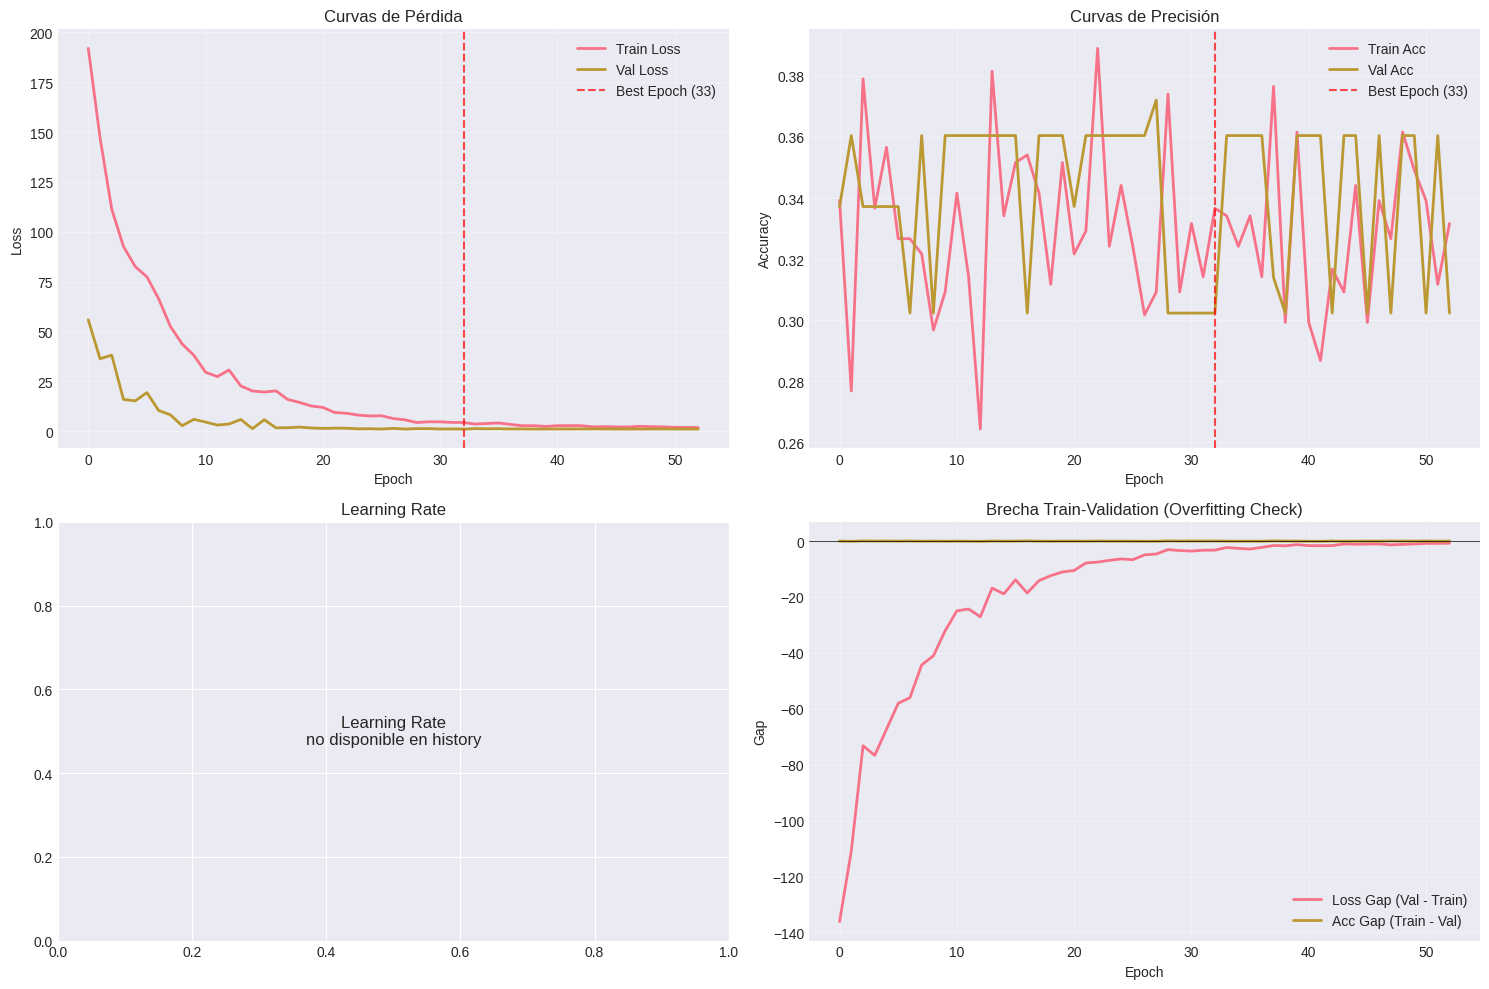

✓ Curvas de aprendizaje guardadas: fig_tensorflow_learning_curves.png


In [ ]:
# ============================================================================
# 7. VISUALIZACIÓN DE CURVAS DE APRENDIZAJE
# ============================================================================

print(f"\n{'='*80}")
print("VISUALIZACIÓN DE CURVAS DE APRENDIZAJE")
print(f"{'='*80}")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

best_epoch = np.argmin(history.history['val_loss']) + 1

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].axvline(x=best_epoch-1, color='r', linestyle='--',
                   label=f'Best Epoch ({best_epoch})', alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Curvas de Pérdida')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Acc', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
axes[0, 1].axvline(x=best_epoch-1, color='r', linestyle='--',
                   label=f'Best Epoch ({best_epoch})', alpha=0.7)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Curvas de Precisión')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning Rate (si está disponible)
if 'lr' in history.history:
    axes[1, 0].plot(history.history['lr'], linewidth=2, color='green')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Evolución del Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'Learning Rate\nno disponible en history',
                    ha='center', va='center', fontsize=12)
    axes[1, 0].set_title('Learning Rate')

# Gap entre train y val
gap_loss = np.array(history.history['val_loss']) - np.array(history.history['loss'])
gap_acc = np.array(history.history['accuracy']) - np.array(history.history['val_accuracy'])

axes[1, 1].plot(gap_loss, label='Loss Gap (Val - Train)', linewidth=2)
axes[1, 1].plot(gap_acc, label='Acc Gap (Train - Val)', linewidth=2)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Gap')
axes[1, 1].set_title('Brecha Train-Validation (Overfitting Check)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig_tensorflow_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Curvas de aprendizaje guardadas: fig_tensorflow_learning_curves.png")


In [ ]:
# ============================================================================
# 8. EVALUACIÓN COMPLETA EN CONJUNTO DE PRUEBA
# ============================================================================

import pandas as pd
import numpy as np
from sklearn.metrics import (accuracy_score, f1_score, matthews_corrcoef,
                             balanced_accuracy_score, cohen_kappa_score,
                             precision_recall_fscore_support, classification_report,
                             recall_score, precision_score)

print(f"\n{'='*80}")
print("EVALUACIÓN COMPLETA EN TEST SET")
print(f"{'='*80}")

# Predicciones
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

# Métricas básicas
accuracy = accuracy_score(y_test, y_pred)
print(f"\n📊 Métricas principales (Test Set):")
print(f"   Accuracy: {accuracy:.4f}")

# Métricas detalladas por clase
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, average=None
)

print(f"\n📈 Métricas por clase:")
print(f"{'Clase':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 60)
class_names = ['Bajo', 'Medio', 'Alto']
for i in range(3):
    print(f"{class_names[i]:<10} {precision[i]:<12.4f} {recall[i]:<12.4f} "
          f"{f1[i]:<12.4f} {support[i]:<10}")

# Métricas globales

f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
matthews = matthews_corrcoef(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
cohen_kappa = cohen_kappa_score(y_test, y_pred)

print(f"\n🎯 Métricas globales:")
print(f"   F1-Score Macro:      {f1_macro:.4f}")
print(f"   F1-Score Weighted:   {f1_weighted:.4f}")
print(f"   Balanced Accuracy:   {balanced_acc:.4f}")
print(f"   Matthews CC:         {matthews:.4f}")
print(f"   Cohen's Kappa:       {cohen_kappa:.4f}")

# Reporte completo
print(f"\n📋 Reporte de Clasificación Completo:")
print(classification_report(y_test, y_pred,
                          target_names=class_names,
                          digits=4))



EVALUACIÓN COMPLETA EN TEST SET

📊 Métricas principales (Test Set):
   Accuracy: 0.3140

📈 Métricas por clase:
Clase      Precision    Recall       F1-Score     Support   
------------------------------------------------------------
Bajo       0.3059       1.0000       0.4685       26        
Medio      1.0000       0.0323       0.0625       31        
Alto       0.0000       0.0000       0.0000       29        

🎯 Métricas globales:
   F1-Score Macro:      0.1770
   F1-Score Weighted:   0.1642
   Balanced Accuracy:   0.3441
   Matthews CC:         0.0886
   Cohen's Kappa:       0.0157

📋 Reporte de Clasificación Completo:
              precision    recall  f1-score   support

        Bajo     0.3059    1.0000    0.4685        26
       Medio     1.0000    0.0323    0.0625        31
        Alto     0.0000    0.0000    0.0000        29

    accuracy                         0.3140        86
   macro avg     0.4353    0.3441    0.1770        86
weighted avg     0.4529    0.3140    0.164


MATRIZ DE CONFUSIÓN


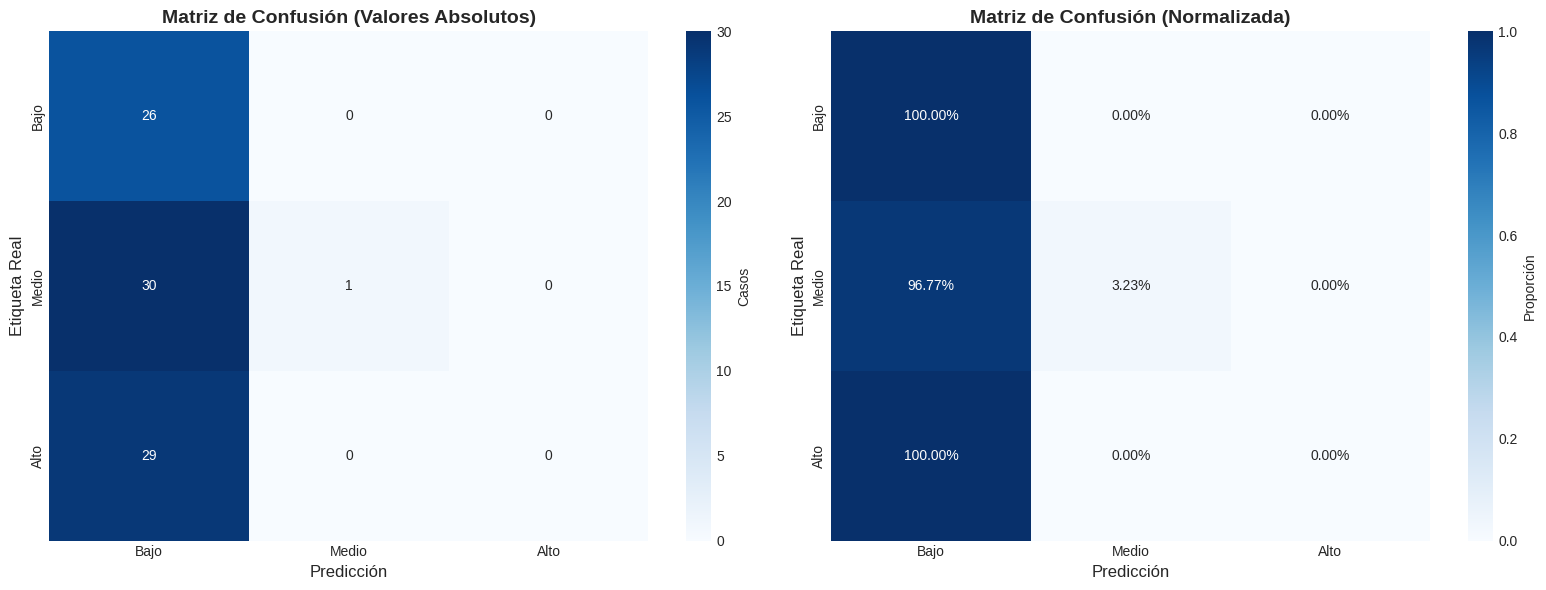

✓ Matriz de confusión guardada: fig_tensorflow_confusion_matrix.png

📊 Métricas Epidemiológicas por Clase:

  Clase Bajo:
    Sensibilidad (Recall): 1.0000
    Especificidad:         0.0167
    VPP (Precision):       0.3059
    VPN:                   1.0000

  Clase Medio:
    Sensibilidad (Recall): 0.0323
    Especificidad:         1.0000
    VPP (Precision):       1.0000
    VPN:                   0.6471

  Clase Alto:
    Sensibilidad (Recall): 0.0000
    Especificidad:         1.0000
    VPP (Precision):       0.0000
    VPN:                   0.6628


In [ ]:
# ============================================================================
# 9. MATRIZ DE CONFUSIÓN
# ============================================================================

print(f"\n{'='*80}")
print("MATRIZ DE CONFUSIÓN")
print(f"{'='*80}")

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz absoluta
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            ax=axes[0], cbar_kws={'label': 'Casos'})
axes[0].set_title('Matriz de Confusión (Valores Absolutos)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Etiqueta Real', fontsize=12)
axes[0].set_xlabel('Predicción', fontsize=12)

# Matriz normalizada
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            ax=axes[1], cbar_kws={'label': 'Proporción'})
axes[1].set_title('Matriz de Confusión (Normalizada)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Etiqueta Real', fontsize=12)
axes[1].set_xlabel('Predicción', fontsize=12)

plt.tight_layout()
plt.savefig('fig_tensorflow_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Matriz de confusión guardada: fig_tensorflow_confusion_matrix.png")

# Métricas epidemiológicas por clase
print(f"\n📊 Métricas Epidemiológicas por Clase:")
for i, clase_nombre in enumerate(class_names):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - TP - FP - FN

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0

    print(f"\n  Clase {clase_nombre}:")
    print(f"    Sensibilidad (Recall): {sensitivity:.4f}")
    print(f"    Especificidad:         {specificity:.4f}")
    print(f"    VPP (Precision):       {ppv:.4f}")
    print(f"    VPN:                   {npv:.4f}")



CURVAS ROC Y AUC


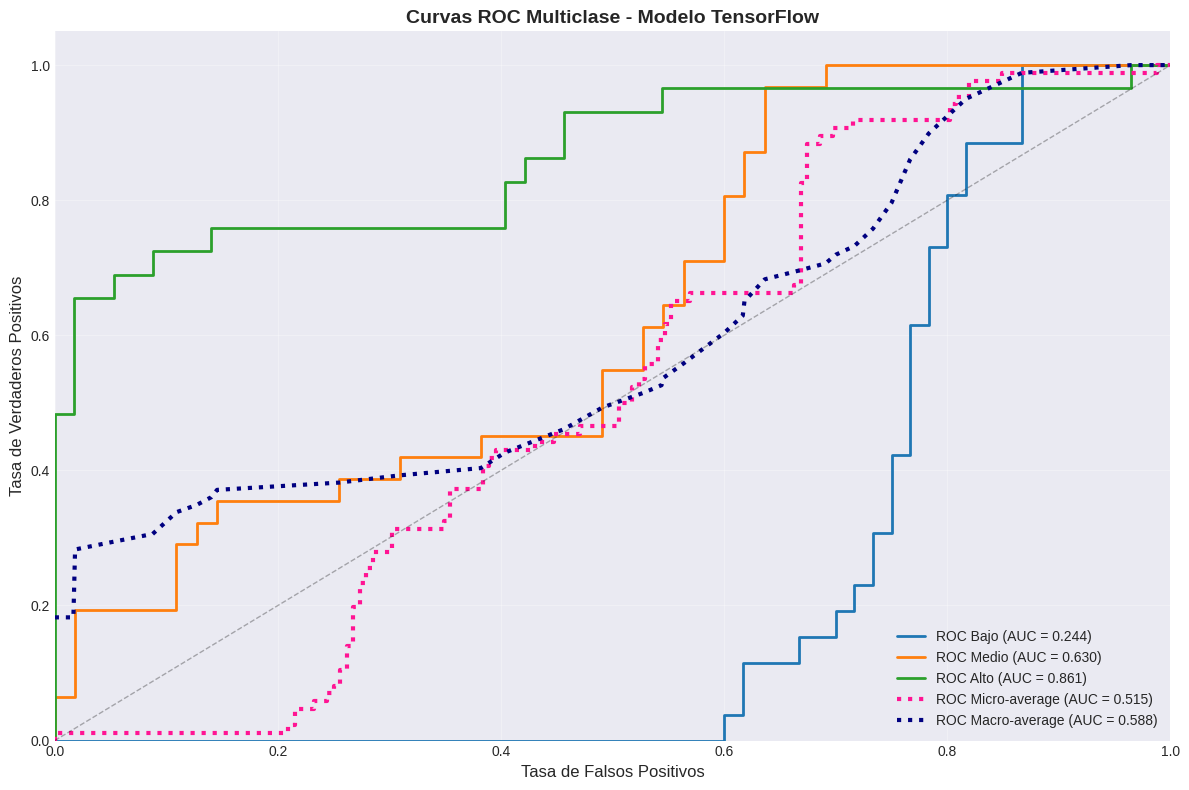

✓ Curvas ROC guardadas: fig_tensorflow_roc_curves.png

📊 AUC-ROC Scores:
   Bajo: 0.2442
   Medio: 0.6305
   Alto: 0.8615
   Micro-average: 0.5151
   Macro-average: 0.5882


In [ ]:
# ============================================================================
# 10. CURVAS ROC Y AUC
# ============================================================================

print(f"\n{'='*80}")
print("CURVAS ROC Y AUC")
print(f"{'='*80}")

# Binarizar labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Calcular ROC y AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ROC macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 3
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Visualizar
plt.figure(figsize=(12, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, color, name in zip(range(3), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC {name} (AUC = {roc_auc[i]:.3f})')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', lw=3,
         label=f'ROC Micro-average (AUC = {roc_auc["micro"]:.3f})')
plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle=':', lw=3,
         label=f'ROC Macro-average (AUC = {roc_auc["macro"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.3)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.title('Curvas ROC Multiclase - Modelo TensorFlow', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig_tensorflow_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Curvas ROC guardadas: fig_tensorflow_roc_curves.png")

print(f"\n📊 AUC-ROC Scores:")
for i, name in enumerate(class_names):
    print(f"   {name}: {roc_auc[i]:.4f}")
print(f"   Micro-average: {roc_auc['micro']:.4f}")
print(f"   Macro-average: {roc_auc['macro']:.4f}")



ANÁLISIS DE CALIBRACIÓN


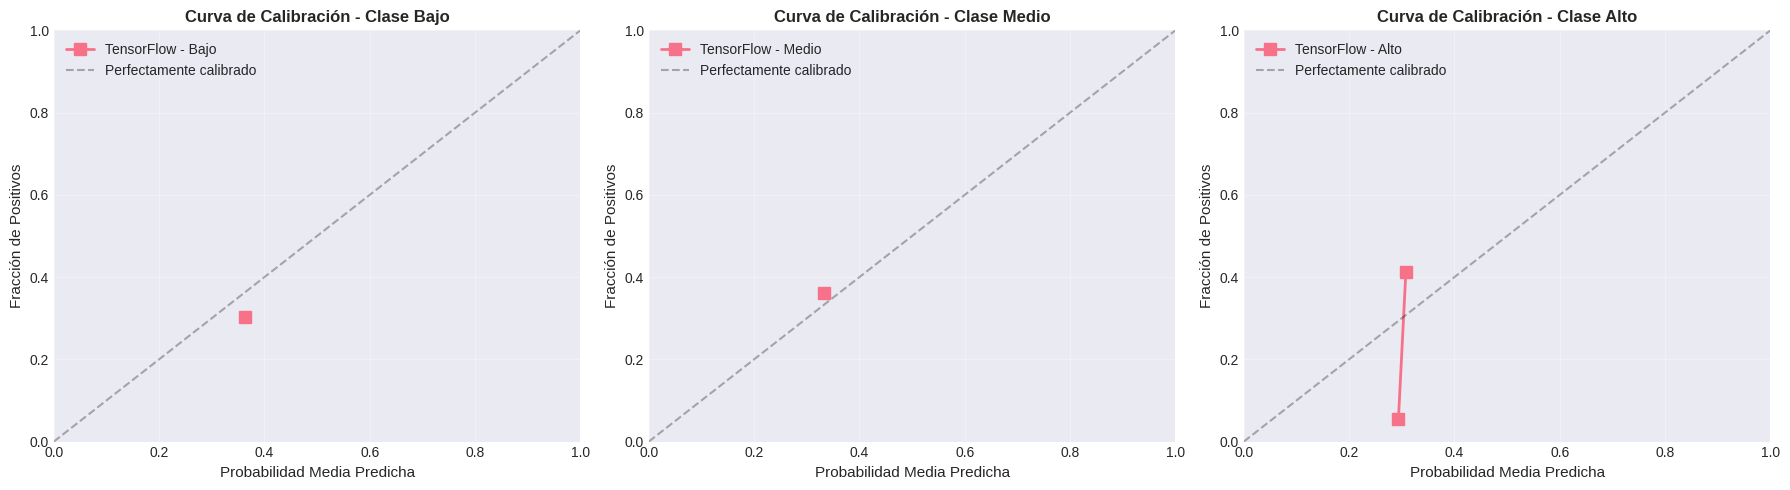

✓ Curvas de calibración guardadas: fig_tensorflow_calibration.png


In [ ]:
# ============================================================================
# 11. CURVA DE CALIBRACIÓN
# ============================================================================

print(f"\n{'='*80}")
print("ANÁLISIS DE CALIBRACIÓN")
print(f"{'='*80}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (ax, name) in enumerate(zip(axes, class_names)):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test_bin[:, i], y_pred_prob[:, i], n_bins=10, strategy='uniform'
    )

    ax.plot(mean_predicted_value, fraction_of_positives, 's-',
            label=f'TensorFlow - {name}', linewidth=2, markersize=8)
    ax.plot([0, 1], [0, 1], 'k--', label='Perfectamente calibrado', alpha=0.3)

    ax.set_xlabel('Probabilidad Media Predicha', fontsize=11)
    ax.set_ylabel('Fracción de Positivos', fontsize=11)
    ax.set_title(f'Curva de Calibración - Clase {name}', fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('fig_tensorflow_calibration.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Curvas de calibración guardadas: fig_tensorflow_calibration.png")



CURVAS PRECISION-RECALL


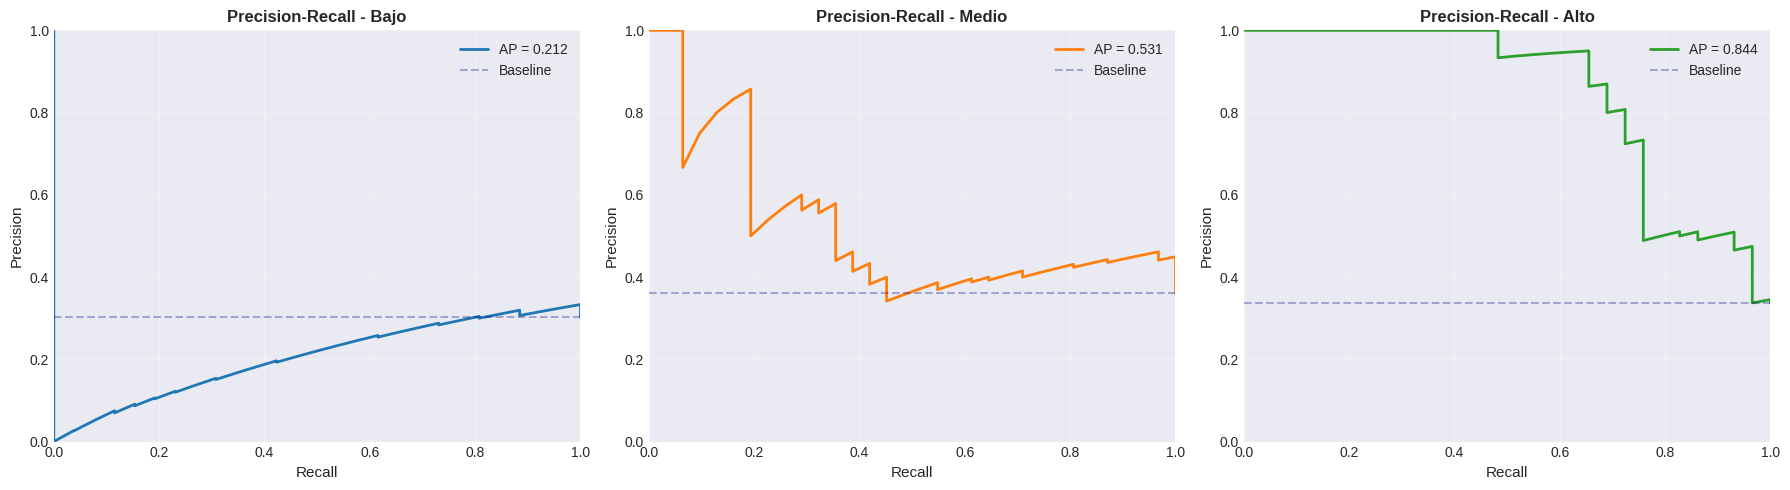

✓ Curvas Precision-Recall guardadas: fig_tensorflow_precision_recall.png


In [ ]:
# ============================================================================
# 12. PRECISION-RECALL CURVES
# ============================================================================

print(f"\n{'='*80}")
print("CURVAS PRECISION-RECALL")
print(f"{'='*80}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (ax, name, color) in enumerate(zip(axes, class_names, colors)):
    precision_curve, recall_curve, _ = precision_recall_curve(
        y_test_bin[:, i], y_pred_prob[:, i]
    )
    avg_precision = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])

    ax.plot(recall_curve, precision_curve, color=color, lw=2,
            label=f'AP = {avg_precision:.3f}')
    ax.axhline(y=y_test_bin[:, i].sum()/len(y_test_bin),
               color='navy', linestyle='--', label='Baseline', alpha=0.3)

    ax.set_xlabel('Recall', fontsize=11)
    ax.set_ylabel('Precision', fontsize=11)
    ax.set_title(f'Precision-Recall - {name}', fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('fig_tensorflow_precision_recall.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Curvas Precision-Recall guardadas: fig_tensorflow_precision_recall.png")



ANÁLISIS DE INCERTIDUMBRE

📊 Estadísticas de Confianza:
   Predicciones correctas:
     - Confianza media:  0.3623
     - Confianza std:    0.0010
     - Entropía media:   1.0956

   Predicciones incorrectas:
     - Confianza media:  0.3626
     - Confianza std:    0.0013
     - Entropía media:   1.0960


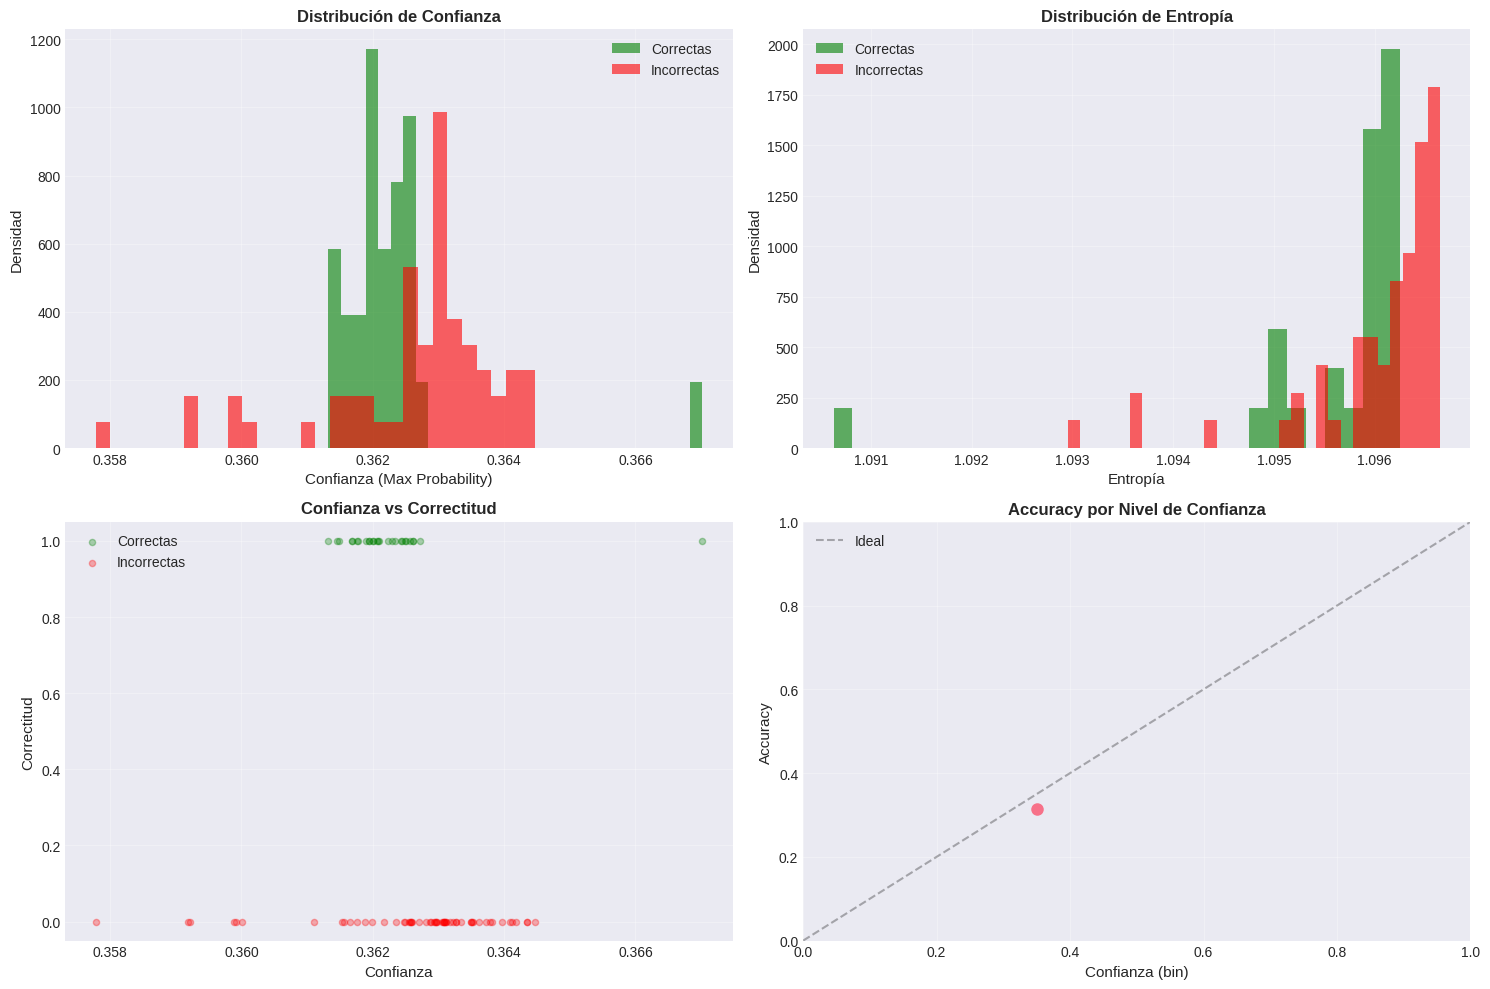

✓ Análisis de incertidumbre guardado: fig_tensorflow_uncertainty.png


In [ ]:
# ============================================================================
# 13. ANÁLISIS DE INCERTIDUMBRE
# ============================================================================

print(f"\n{'='*80}")
print("ANÁLISIS DE INCERTIDUMBRE")
print(f"{'='*80}")

# Calcular métricas de incertidumbre
confidence_scores = np.max(y_pred_prob, axis=1)
entropy_scores = -np.sum(y_pred_prob * np.log(y_pred_prob + 1e-10), axis=1)

# Analizar por correctitud
correct_mask = (y_pred == y_test)
incorrect_mask = ~correct_mask

print(f"\n📊 Estadísticas de Confianza:")
print(f"   Predicciones correctas:")
print(f"     - Confianza media:  {confidence_scores[correct_mask].mean():.4f}")
print(f"     - Confianza std:    {confidence_scores[correct_mask].std():.4f}")
print(f"     - Entropía media:   {entropy_scores[correct_mask].mean():.4f}")

if incorrect_mask.sum() > 0:
    print(f"\n   Predicciones incorrectas:")
    print(f"     - Confianza media:  {confidence_scores[incorrect_mask].mean():.4f}")
    print(f"     - Confianza std:    {confidence_scores[incorrect_mask].std():.4f}")
    print(f"     - Entropía media:   {entropy_scores[incorrect_mask].mean():.4f}")

# Visualizar
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma de confianza
axes[0, 0].hist(confidence_scores[correct_mask], bins=30, alpha=0.6,
                label='Correctas', color='green', density=True)
if incorrect_mask.sum() > 0:
    axes[0, 0].hist(confidence_scores[incorrect_mask], bins=30, alpha=0.6,
                    label='Incorrectas', color='red', density=True)
axes[0, 0].set_xlabel('Confianza (Max Probability)', fontsize=11)
axes[0, 0].set_ylabel('Densidad', fontsize=11)
axes[0, 0].set_title('Distribución de Confianza', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Histograma de entropía
axes[0, 1].hist(entropy_scores[correct_mask], bins=30, alpha=0.6,
                label='Correctas', color='green', density=True)
if incorrect_mask.sum() > 0:
    axes[0, 1].hist(entropy_scores[incorrect_mask], bins=30, alpha=0.6,
                    label='Incorrectas', color='red', density=True)
axes[0, 1].set_xlabel('Entropía', fontsize=11)
axes[0, 1].set_ylabel('Densidad', fontsize=11)
axes[0, 1].set_title('Distribución de Entropía', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Scatter: Confianza vs Correctitud
axes[1, 0].scatter(confidence_scores[correct_mask],
                   np.ones(correct_mask.sum()),
                   alpha=0.3, c='green', label='Correctas', s=20)
if incorrect_mask.sum() > 0:
    axes[1, 0].scatter(confidence_scores[incorrect_mask],
                       np.zeros(incorrect_mask.sum()),
                       alpha=0.3, c='red', label='Incorrectas', s=20)
axes[1, 0].set_xlabel('Confianza', fontsize=11)
axes[1, 0].set_ylabel('Correctitud', fontsize=11)
axes[1, 0].set_title('Confianza vs Correctitud', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Accuracy por bins de confianza
bins = np.linspace(0, 1, 11)
bin_indices = np.digitize(confidence_scores, bins)
bin_accuracies = []
bin_centers = []

for i in range(1, len(bins)):
    mask = (bin_indices == i)
    if mask.sum() > 0:
        acc = (y_pred[mask] == y_test[mask]).mean()
        bin_accuracies.append(acc)
        bin_centers.append((bins[i-1] + bins[i]) / 2)

axes[1, 1].plot(bin_centers, bin_accuracies, 'o-', linewidth=2, markersize=8)
axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Ideal')
axes[1, 1].set_xlabel('Confianza (bin)', fontsize=11)
axes[1, 1].set_ylabel('Accuracy', fontsize=11)
axes[1, 1].set_title('Accuracy por Nivel de Confianza', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim([0, 1])
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('fig_tensorflow_uncertainty.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Análisis de incertidumbre guardado: fig_tensorflow_uncertainty.png")



VALIDACIÓN CRUZADA ESTRATIFICADA (5-FOLD)

Ejecutando validación cruzada con 5 folds...
--------------------------------------------------------------------------------

Fold 1/5
----------------------------------------
  Val Acc: 0.3673 | F1-Macro: 0.1641 | AUC: 0.5074

Fold 2/5
----------------------------------------


  Val Acc: 0.3673 | F1-Macro: 0.2815 | AUC: 0.5228

Fold 3/5
----------------------------------------
  Val Acc: 0.3299 | F1-Macro: 0.1768 | AUC: 0.4926

Fold 4/5
----------------------------------------
  Val Acc: 0.3299 | F1-Macro: 0.1654 | AUC: 0.4040

Fold 5/5
----------------------------------------
  Val Acc: 0.3299 | F1-Macro: 0.1768 | AUC: 0.4736

RESULTADOS DE VALIDACIÓN CRUZADA

📊 Resultados por fold:
 fold  train_acc  val_acc  train_loss  val_loss  f1_macro  f1_weighted  balanced_acc  matthews_cc  auc_macro
    1     0.3290   0.3673      3.5012    1.3895    0.1641       0.1608        0.3333       0.0000     0.5074
    2     0.3470   0.3673     14.4908    5.7769    0.2815       0.2983        0.3392       0.0146     0.5228
    3     0.3308   0.3299      1.7536    1.0985    0.1768       0.1913        0.3333       0.0000     0.4926
    4     0.3590   0.3299      1.8911    1.1834    0.1654       0.1637        0.3333       0.0000     0.4040
    5     0.3359   0.3299      2.3060   

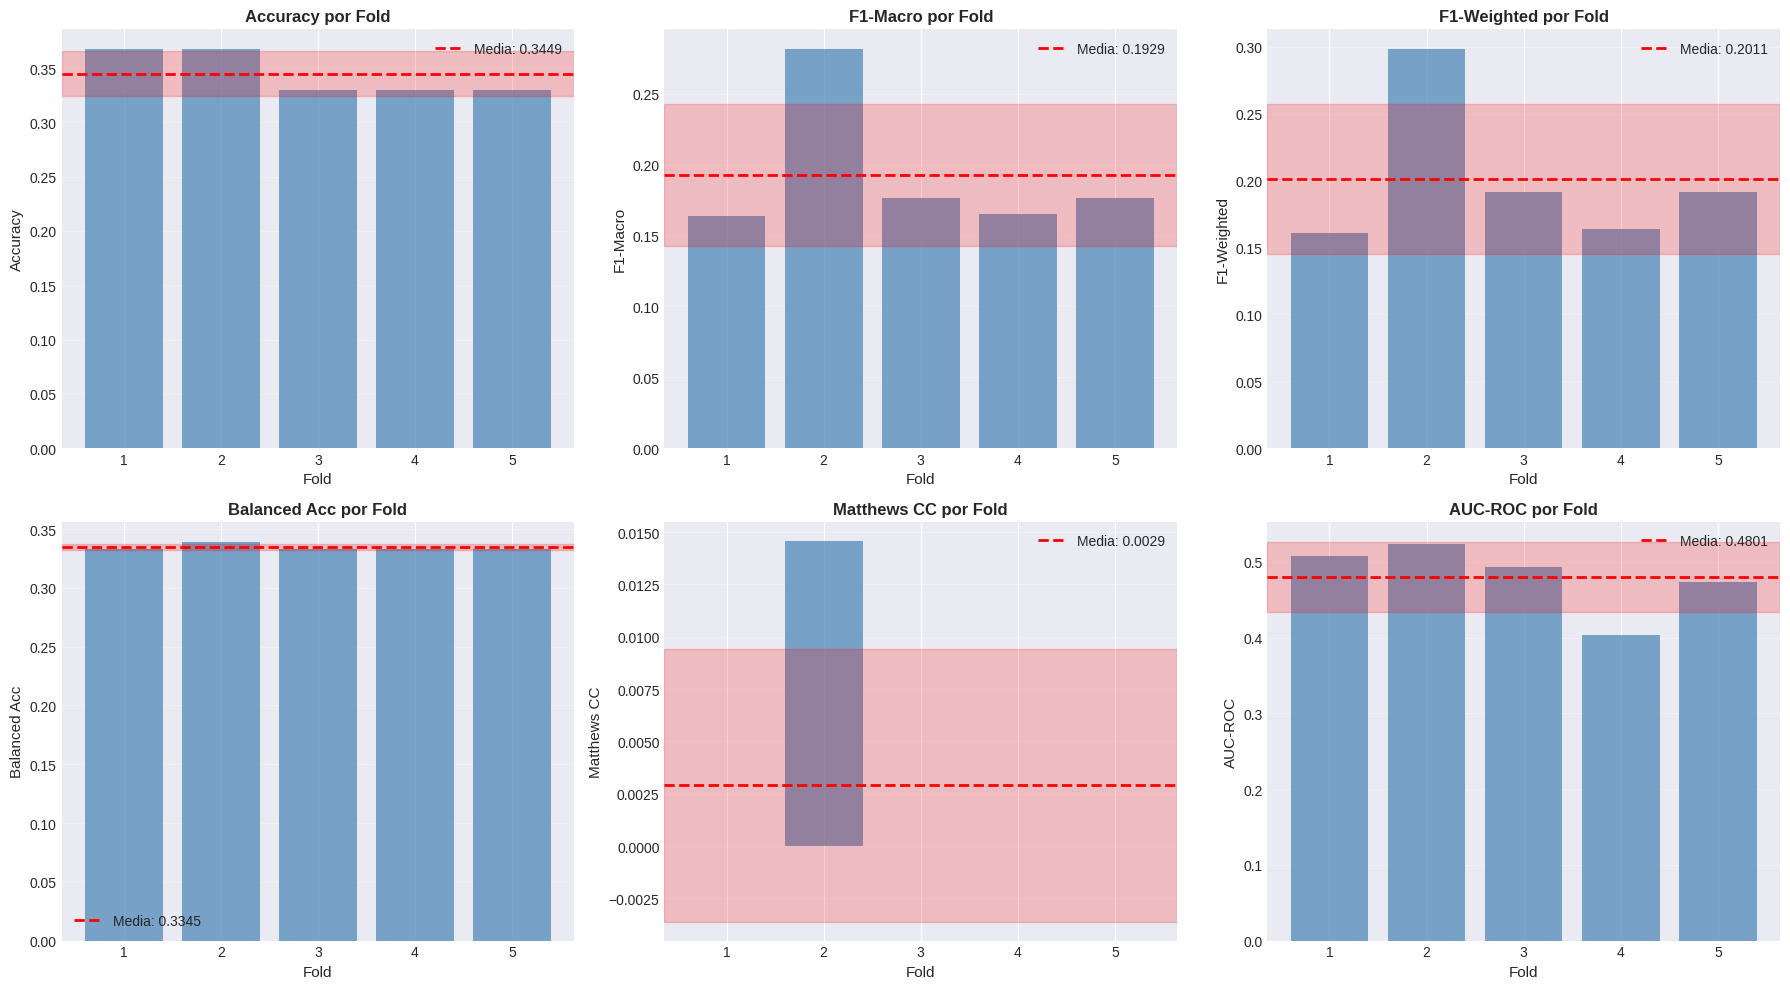


✓ Resultados de CV guardados: fig_tensorflow_cross_validation.png
✓ Resultados de CV guardados: cross_validation_results_tensorflow.csv


In [ ]:
# ============================================================================
# 14. VALIDACIÓN CRUZADA ESTRATIFICADA (K-FOLD)
# ============================================================================

print(f"\n{'='*80}")
print("VALIDACIÓN CRUZADA ESTRATIFICADA (5-FOLD)")
print(f"{'='*80}")

# Configuración
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

# Almacenar resultados
cv_results = {
    'fold': [],
    'train_acc': [],
    'val_acc': [],
    'train_loss': [],
    'val_loss': [],
    'f1_macro': [],
    'f1_weighted': [],
    'balanced_acc': [],
    'matthews_cc': [],
    'auc_macro': []
}

print(f"\nEjecutando validación cruzada con {N_SPLITS} folds...")
print("-" * 80)

# Usar solo el conjunto de entrenamiento completo para CV
for fold, (train_idx, val_idx) in enumerate(skf.split(X_temp, y_temp)):
    print(f"\nFold {fold + 1}/{N_SPLITS}")
    print("-" * 40)

    # Dividir datos
    X_fold_train, X_fold_val = X_temp[train_idx], X_temp[val_idx]
    y_fold_train, y_fold_val = y_temp[train_idx], y_temp[val_idx]

    # Convertir a categorical
    y_fold_train_cat = to_categorical(y_fold_train, num_classes=3)
    y_fold_val_cat = to_categorical(y_fold_val, num_classes=3)

    # Crear nuevo modelo
    fold_model = create_model(
        input_dim=input_dim,
        hidden_dims=[128, 64, 32],
        dropout_rates=[0.3, 0.2],
        learning_rate=0.001
    )

    # Entrenar (con menos epochs para CV)
    fold_history = fold_model.fit(
        X_fold_train, y_fold_train_cat,
        validation_data=(X_fold_val, y_fold_val_cat),
        epochs=100,  # Menos epochs para CV
        batch_size=BATCH_SIZE,
        class_weight=class_weights,
        callbacks=[
            callbacks.EarlyStopping(monitor='val_loss', patience=15,
                                   restore_best_weights=True, verbose=0)
        ],
        verbose=0
    )

    # Evaluar
    train_loss = fold_history.history['loss'][-1]
    val_loss = fold_history.history['val_loss'][-1]
    train_acc = fold_history.history['accuracy'][-1]
    val_acc = fold_history.history['val_accuracy'][-1]

    # Predicciones
    y_pred_fold_prob = fold_model.predict(X_fold_val, verbose=0)
    y_pred_fold = np.argmax(y_pred_fold_prob, axis=1)

    # Métricas
    f1_mac = f1_score(y_fold_val, y_pred_fold, average='macro')
    f1_wei = f1_score(y_fold_val, y_pred_fold, average='weighted')
    bal_acc = balanced_accuracy_score(y_fold_val, y_pred_fold)
    mcc = matthews_corrcoef(y_fold_val, y_pred_fold)

    # AUC
    y_fold_val_bin = label_binarize(y_fold_val, classes=[0, 1, 2])
    auc_mac = roc_auc_score(y_fold_val_bin, y_pred_fold_prob,
                           average='macro', multi_class='ovr')

    # Guardar resultados
    cv_results['fold'].append(fold + 1)
    cv_results['train_acc'].append(train_acc)
    cv_results['val_acc'].append(val_acc)
    cv_results['train_loss'].append(train_loss)
    cv_results['val_loss'].append(val_loss)
    cv_results['f1_macro'].append(f1_mac)
    cv_results['f1_weighted'].append(f1_wei)
    cv_results['balanced_acc'].append(bal_acc)
    cv_results['matthews_cc'].append(mcc)
    cv_results['auc_macro'].append(auc_mac)

    print(f"  Val Acc: {val_acc:.4f} | F1-Macro: {f1_mac:.4f} | AUC: {auc_mac:.4f}")

print("\n" + "=" * 80)
print("RESULTADOS DE VALIDACIÓN CRUZADA")
print("=" * 80)

cv_df = pd.DataFrame(cv_results)

# Mostrar resultados
print("\n📊 Resultados por fold:")
print(cv_df.to_string(index=False, float_format='%.4f'))

# Estadísticas
print("\n📈 Estadísticas resumen:")
metrics_to_summarize = ['val_acc', 'f1_macro', 'balanced_acc', 'matthews_cc', 'auc_macro']
summary_stats = cv_df[metrics_to_summarize].describe().loc[['mean', 'std']]
print(summary_stats.to_string(float_format='%.4f'))

# Visualizar
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

metrics = ['val_acc', 'f1_macro', 'f1_weighted', 'balanced_acc', 'matthews_cc', 'auc_macro']
titles = ['Accuracy', 'F1-Macro', 'F1-Weighted', 'Balanced Acc', 'Matthews CC', 'AUC-ROC']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx]

    ax.bar(cv_df['fold'], cv_df[metric], alpha=0.7, color='steelblue')

    mean_val = cv_df[metric].mean()
    ax.axhline(y=mean_val, color='red', linestyle='--', linewidth=2,
               label=f'Media: {mean_val:.4f}')

    std_val = cv_df[metric].std()
    ax.axhspan(mean_val - std_val, mean_val + std_val, alpha=0.2, color='red')

    ax.set_xlabel('Fold', fontsize=11)
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(f'{title} por Fold', fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticks(cv_df['fold'])

plt.tight_layout()
plt.savefig('fig_tensorflow_cross_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Resultados de CV guardados: fig_tensorflow_cross_validation.png")

# Guardar resultados
cv_df.to_csv('cross_validation_results_tensorflow.csv', index=False)
print("✓ Resultados de CV guardados: cross_validation_results_tensorflow.csv")



COMPARACIÓN DETALLADA ENTRE CONJUNTOS

📊 Tabla Comparativa Completa:
  Conjunto  Accuracy  Balanced_Acc  F1_Macro  F1_Weighted  Sensibilidad  Precision  AUC_Macro  AUC_Weighted  Matthews_CC  Cohen_Kappa
     Train    0.3142        0.3402    0.1708       0.1595        0.3402     0.4363     0.5884        0.5990       0.0710       0.0102
Validation    0.3023        0.3333    0.1548       0.1404        0.3333     0.1008     0.5242        0.5360       0.0000       0.0000
      Test    0.3140        0.3441    0.1770       0.1642        0.3441     0.4353     0.5787        0.5916       0.0886       0.0157


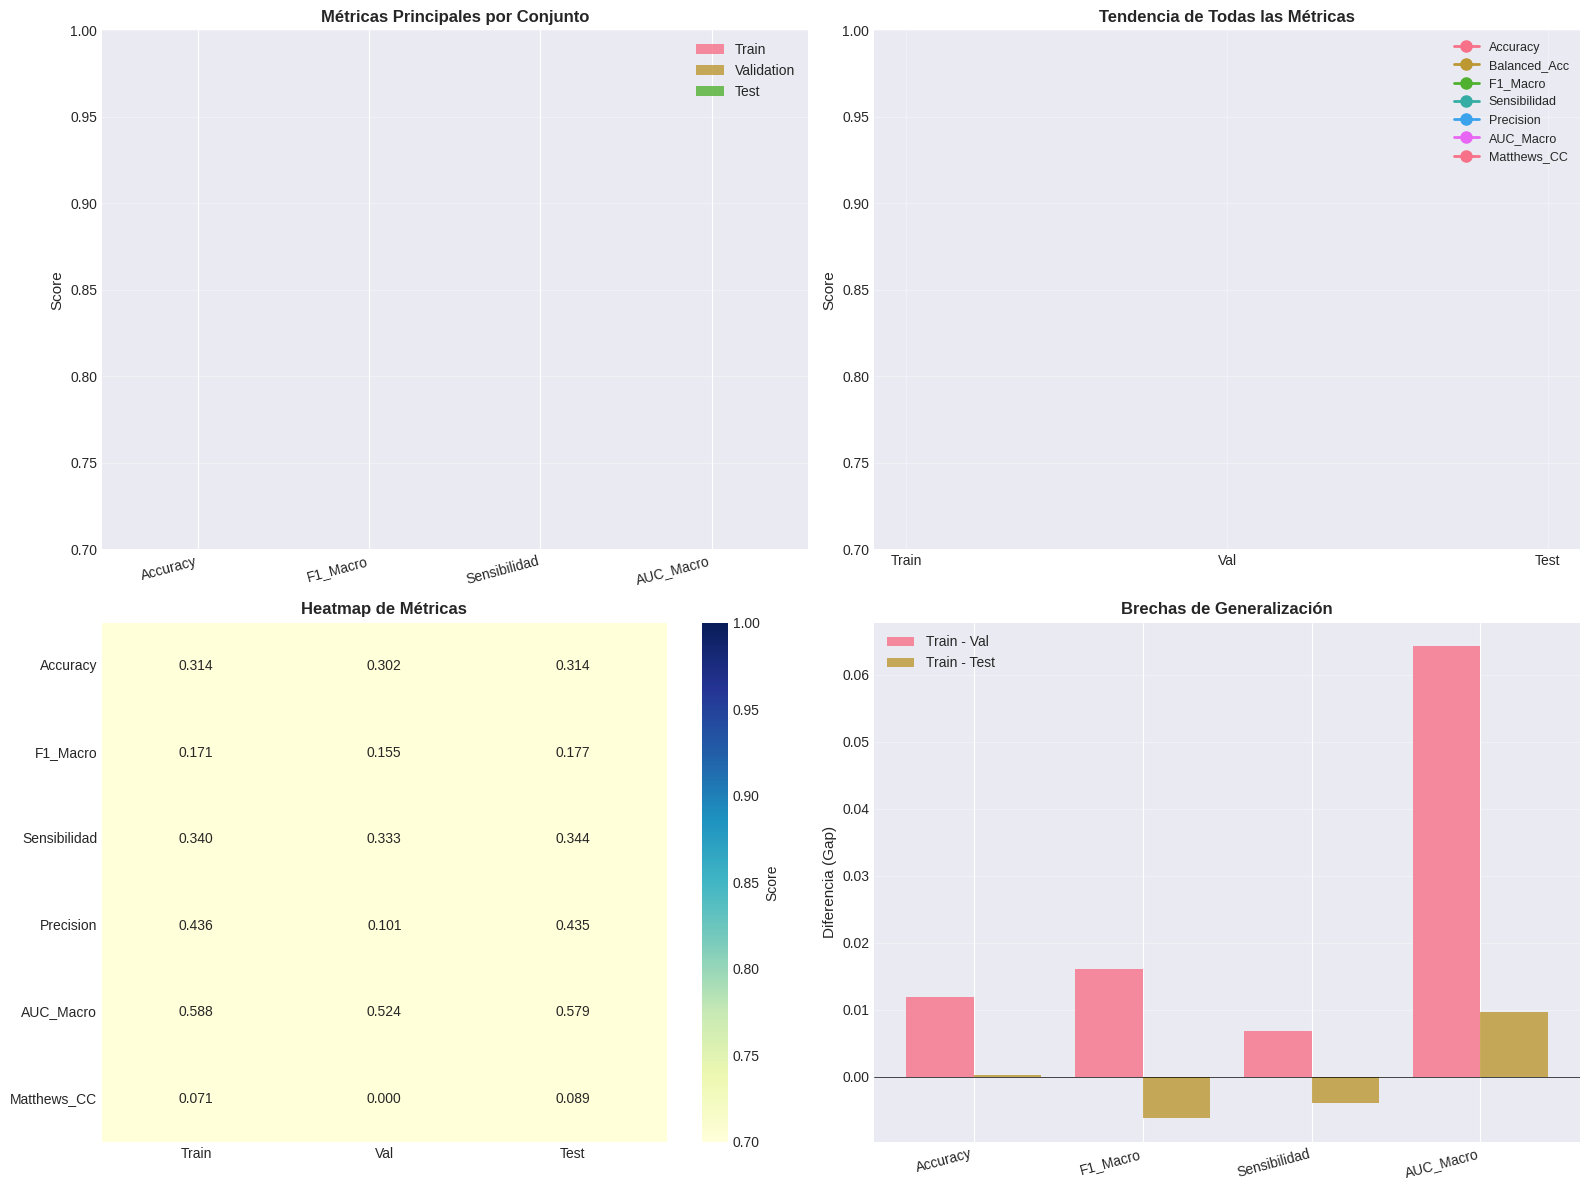


✓ Comparación entre conjuntos guardada: fig_tensorflow_sets_comparison.png
✓ Tabla guardada: sets_comparison_tensorflow.csv

⚠️  Análisis de Overfitting:
   Gap Accuracy (Train - Test): 0.0003
   ✓ No hay evidencia de overfitting significativo


In [ ]:
# ============================================================================
# 15. COMPARACIÓN DETALLADA ENTRE CONJUNTOS
# ============================================================================

print(f"\n{'='*80}")
print("COMPARACIÓN DETALLADA ENTRE CONJUNTOS")
print(f"{'='*80}")

# Evaluar en todos los conjuntos
sets_to_evaluate = [
    ('Train', X_train, y_train),
    ('Validation', X_val, y_val),
    ('Test', X_test, y_test)
]

comparison_results = []

for set_name, X_set, y_set in sets_to_evaluate:
    # Predicciones
    y_pred_set_prob = model.predict(X_set, verbose=0)
    y_pred_set = np.argmax(y_pred_set_prob, axis=1)

    # Métricas
    acc = accuracy_score(y_set, y_pred_set)
    f1_mac = f1_score(y_set, y_pred_set, average='macro')
    f1_wei = f1_score(y_set, y_pred_set, average='weighted')
    bal_acc = balanced_accuracy_score(y_set, y_pred_set)
    mcc = matthews_corrcoef(y_set, y_pred_set)
    kappa = cohen_kappa_score(y_set, y_pred_set)

    sens = recall_score(y_set, y_pred_set, average='macro')
    prec = precision_score(y_set, y_pred_set, average='macro')

    # AUC
    y_set_bin = label_binarize(y_set, classes=[0, 1, 2])
    auc_mac = roc_auc_score(y_set_bin, y_pred_set_prob, average='macro', multi_class='ovr')
    auc_wei = roc_auc_score(y_set_bin, y_pred_set_prob, average='weighted', multi_class='ovr')

    comparison_results.append({
        'Conjunto': set_name,
        'Accuracy': acc,
        'Balanced_Acc': bal_acc,
        'F1_Macro': f1_mac,
        'F1_Weighted': f1_wei,
        'Sensibilidad': sens,
        'Precision': prec,
        'AUC_Macro': auc_mac,
        'AUC_Weighted': auc_wei,
        'Matthews_CC': mcc,
        'Cohen_Kappa': kappa
    })

comparison_df = pd.DataFrame(comparison_results)

print("\n📊 Tabla Comparativa Completa:")
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Visualizar
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Métricas principales
metrics_main = ['Accuracy', 'F1_Macro', 'Sensibilidad', 'AUC_Macro']
x = np.arange(len(metrics_main))
width = 0.25

for i, conjunto in enumerate(['Train', 'Validation', 'Test']):
    data = comparison_df[comparison_df['Conjunto'] == conjunto]
    values = [data[m].values[0] for m in metrics_main]
    axes[0, 0].bar(x + i*width, values, width, label=conjunto, alpha=0.8)

axes[0, 0].set_ylabel('Score', fontsize=11)
axes[0, 0].set_title('Métricas Principales por Conjunto', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x + width)
axes[0, 0].set_xticklabels(metrics_main, rotation=15, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].set_ylim([0.7, 1.0])

# Gráfico 2: Todas las métricas
metrics_all = ['Accuracy', 'Balanced_Acc', 'F1_Macro', 'Sensibilidad',
               'Precision', 'AUC_Macro', 'Matthews_CC']
for metric in metrics_all:
    axes[0, 1].plot(['Train', 'Val', 'Test'],
                   comparison_df[metric].values,
                   marker='o', linewidth=2, markersize=8, label=metric)

axes[0, 1].set_ylabel('Score', fontsize=11)
axes[0, 1].set_title('Tendencia de Todas las Métricas', fontsize=12, fontweight='bold')
axes[0, 1].legend(loc='best', fontsize=9)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0.7, 1.0])

# Gráfico 3: Heatmap
metrics_heatmap = ['Accuracy', 'F1_Macro', 'Sensibilidad', 'Precision',
                   'AUC_Macro', 'Matthews_CC']
heatmap_data = comparison_df[metrics_heatmap].values.T

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=['Train', 'Val', 'Test'],
            yticklabels=metrics_heatmap,
            ax=axes[1, 0], cbar_kws={'label': 'Score'}, vmin=0.7, vmax=1.0)
axes[1, 0].set_title('Heatmap de Métricas', fontsize=12, fontweight='bold')

# Gráfico 4: Diferencias
train_vals = comparison_df[comparison_df['Conjunto'] == 'Train'][metrics_main].values[0]
val_vals = comparison_df[comparison_df['Conjunto'] == 'Validation'][metrics_main].values[0]
test_vals = comparison_df[comparison_df['Conjunto'] == 'Test'][metrics_main].values[0]

gap_train_val = train_vals - val_vals
gap_train_test = train_vals - test_vals

x_pos = np.arange(len(metrics_main))
axes[1, 1].bar(x_pos - 0.2, gap_train_val, 0.4, label='Train - Val', alpha=0.8)
axes[1, 1].bar(x_pos + 0.2, gap_train_test, 0.4, label='Train - Test', alpha=0.8)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

axes[1, 1].set_ylabel('Diferencia (Gap)', fontsize=11)
axes[1, 1].set_title('Brechas de Generalización', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(metrics_main, rotation=15, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fig_tensorflow_sets_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparación entre conjuntos guardada: fig_tensorflow_sets_comparison.png")

# Guardar tabla
comparison_df.to_csv('sets_comparison_tensorflow.csv', index=False)
print("✓ Tabla guardada: sets_comparison_tensorflow.csv")

# Análisis de overfitting
train_acc = comparison_df[comparison_df['Conjunto'] == 'Train']['Accuracy'].values[0]
test_acc = comparison_df[comparison_df['Conjunto'] == 'Test']['Accuracy'].values[0]
gap_acc = train_acc - test_acc

print(f"\n⚠️  Análisis de Overfitting:")
print(f"   Gap Accuracy (Train - Test): {gap_acc:.4f}")
if gap_acc < 0.05:
    print("   ✓ No hay evidencia de overfitting significativo")
elif gap_acc < 0.10:
    print("   ⚠️  Overfitting leve detectado")
else:
    print("   ❌ Overfitting moderado/severo detectado")



In [ ]:
# ============================================================================
# 16. ANÁLISIS DETALLADO DE ERRORES
# ============================================================================

print(f"\n{'='*80}")
print("ANÁLISIS DETALLADO DE ERRORES")
print(f"{'='*80}")

# Identificar casos mal clasificados
error_indices = np.where(y_pred != y_test)[0]
correct_indices = np.where(y_pred == y_test)[0]

print(f"\n📊 Resumen de predicciones:")
print(f"   Total de casos: {len(y_test)}")
print(f"   Correctos: {len(correct_indices)} ({len(correct_indices)/len(y_test)*100:.2f}%)")
print(f"   Errores: {len(error_indices)} ({len(error_indices)/len(y_test)*100:.2f}%)")

# Analizar patrones de error
error_patterns = defaultdict(int)
for idx in error_indices:
    true_class = y_test[idx]
    pred_class = y_pred[idx]
    error_patterns[(true_class, pred_class)] += 1

print(f"\n🔍 Patrones de error más comunes:")
sorted_errors = sorted(error_patterns.items(), key=lambda x: x[1], reverse=True)
class_names_dict = {0: 'Bajo', 1: 'Medio', 2: 'Alto'}

for (true_cls, pred_cls), count in sorted_errors:
    pct = count / len(error_indices) * 100 if len(error_indices) > 0 else 0
    print(f"   {class_names_dict[true_cls]} → {class_names_dict[pred_cls]}: "
          f"{count} casos ({pct:.1f}% de errores)")

# Analizar confianza en errores
error_confidences = confidence_scores[error_indices]
correct_confidences = confidence_scores[correct_indices]

print(f"\n📊 Confianza en predicciones:")
print(f"   Correctas - Media: {correct_confidences.mean():.4f}, Std: {correct_confidences.std():.4f}")
if len(error_confidences) > 0:
    print(f"   Errores   - Media: {error_confidences.mean():.4f}, Std: {error_confidences.std():.4f}")

# Casos con mayor incertidumbre
most_uncertain_indices = np.argsort(entropy_scores)[-10:][::-1]

print(f"\n🎯 Top 10 casos con mayor incertidumbre:")
print(f"{'Idx':<6} {'True':<6} {'Pred':<6} {'Entropía':<10} {'Confianza':<10} {'Correcto':<10}")
print("-" * 60)
for idx in most_uncertain_indices:
    print(f"{idx:<6} {y_test[idx]:<6} {y_pred[idx]:<6} "
          f"{entropy_scores[idx]:<10.4f} {confidence_scores[idx]:<10.4f} "
          f"{'✓' if y_pred[idx] == y_test[idx] else '✗':<10}")



ANÁLISIS DETALLADO DE ERRORES

📊 Resumen de predicciones:
   Total de casos: 86
   Correctos: 27 (31.40%)
   Errores: 59 (68.60%)

🔍 Patrones de error más comunes:
   Medio → Bajo: 30 casos (50.8% de errores)
   Alto → Bajo: 29 casos (49.2% de errores)

📊 Confianza en predicciones:
   Correctas - Media: 0.3623, Std: 0.0010
   Errores   - Media: 0.3626, Std: 0.0013

🎯 Top 10 casos con mayor incertidumbre:
Idx    True   Pred   Entropía   Confianza  Correcto  
------------------------------------------------------------
56     2      0      1.0967     0.3629     ✗         
29     2      0      1.0966     0.3630     ✗         
68     2      0      1.0966     0.3630     ✗         
15     2      0      1.0966     0.3631     ✗         
82     2      0      1.0966     0.3633     ✗         
50     2      0      1.0966     0.3631     ✗         
7      2      0      1.0966     0.3631     ✗         
38     2      0      1.0966     0.3626     ✗         
10     2      0      1.0966     0.3632     ✗

In [ ]:
# ============================================================================
# 17. EXPLICABILIDAD CON SHAP
# ============================================================================

print(f"\n{'='*80}")
print("ANÁLISIS DE EXPLICABILIDAD CON SHAP")
print(f"{'='*80}")

print("\nInstalando SHAP si es necesario...")
try:
    import shap
    print("✓ SHAP ya está instalado")
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'shap', '--break-system-packages'])
    import shap
    print("✓ SHAP instalado correctamente")

# Crear wrapper para TensorFlow/Keras
class KerasModelWrapper:
    def __init__(self, model):
        self.model = model

    def __call__(self, X):
        return self.model.predict(X, verbose=0)

# Wrapper del modelo
model_wrapper = KerasModelWrapper(model)

# Seleccionar muestra para SHAP
n_background = min(100, len(X_train))
background_data = X_train[:n_background]

n_explain = min(100, len(X_test))
test_sample = X_test[:n_explain]

print(f"\n⚙️  Configuración SHAP:")
print(f"   Background samples: {n_background}")
print(f"   Test samples para explicar: {n_explain}")

# Crear explainer
print("\nCreando SHAP explainer (esto puede tomar unos minutos)...")
explainer = shap.KernelExplainer(model_wrapper, background_data)

# Calcular SHAP values
print("Calculando SHAP values...")
shap_values = explainer.shap_values(test_sample, nsamples=100)

print("✓ SHAP values calculados")


ANÁLISIS DE EXPLICABILIDAD CON SHAP

Instalando SHAP si es necesario...
✓ SHAP ya está instalado

⚙️  Configuración SHAP:
   Background samples: 100
   Test samples para explicar: 86

Creando SHAP explainer (esto puede tomar unos minutos)...
Calculando SHAP values...


  0%|          | 0/86 [00:00<?, ?it/s]

✓ SHAP values calculados



📊 Generando visualizaciones SHAP...


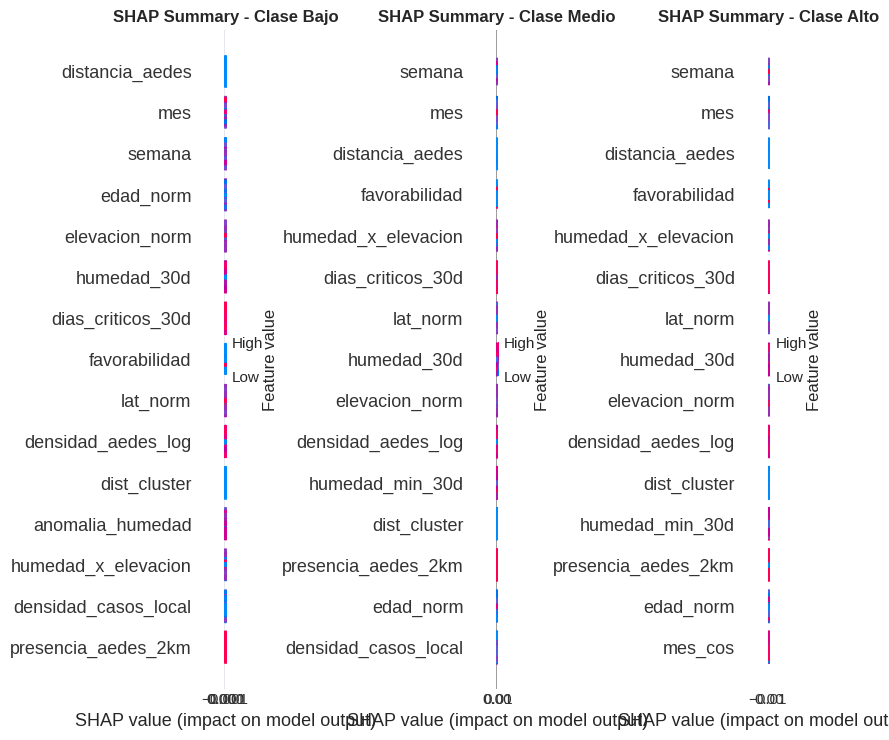

✓ SHAP summary plots guardados: fig_tensorflow_shap_summary.png

📊 Importancia de Features (SHAP):

  Top 10 features - Clase Bajo:
     1. distancia_aedes          : 0.0002
     2. mes                      : 0.0001
     3. semana                   : 0.0001
     4. edad_norm                : 0.0001
     5. elevacion_norm           : 0.0001
     6. humedad_30d              : 0.0001
     7. dias_criticos_30d        : 0.0001
     8. favorabilidad            : 0.0001
     9. lat_norm                 : 0.0001
    10. densidad_aedes_log       : 0.0001

  Top 10 features - Clase Medio:
     1. semana                   : 0.0039
     2. mes                      : 0.0016
     3. distancia_aedes          : 0.0010
     4. favorabilidad            : 0.0009
     5. humedad_x_elevacion      : 0.0008
     6. dias_criticos_30d        : 0.0007
     7. lat_norm                 : 0.0006
     8. humedad_30d              : 0.0006
     9. elevacion_norm           : 0.0006
    10. densidad_aedes_log       : 0

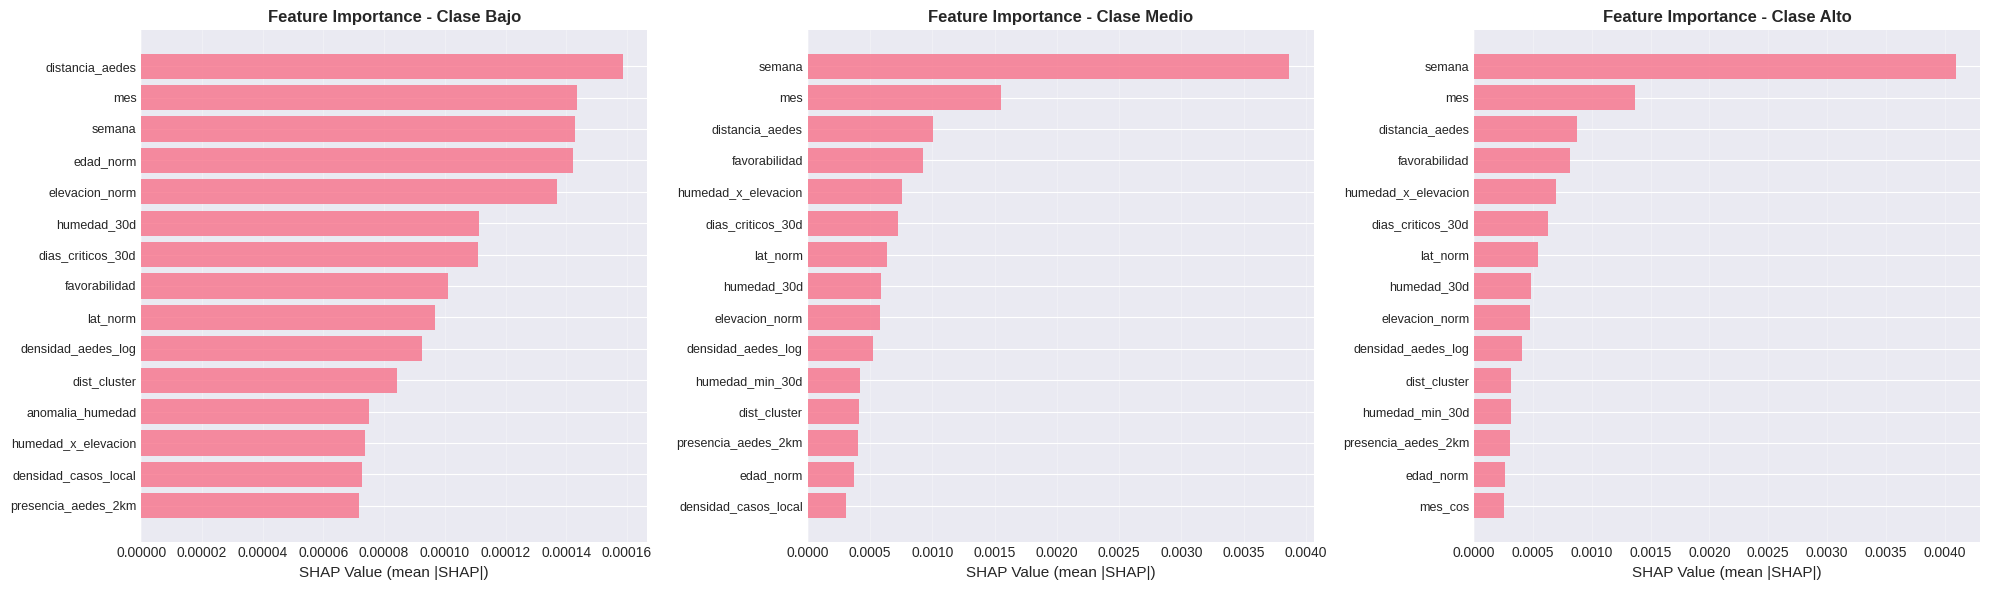

✓ SHAP importance guardado: fig_tensorflow_shap_importance.png


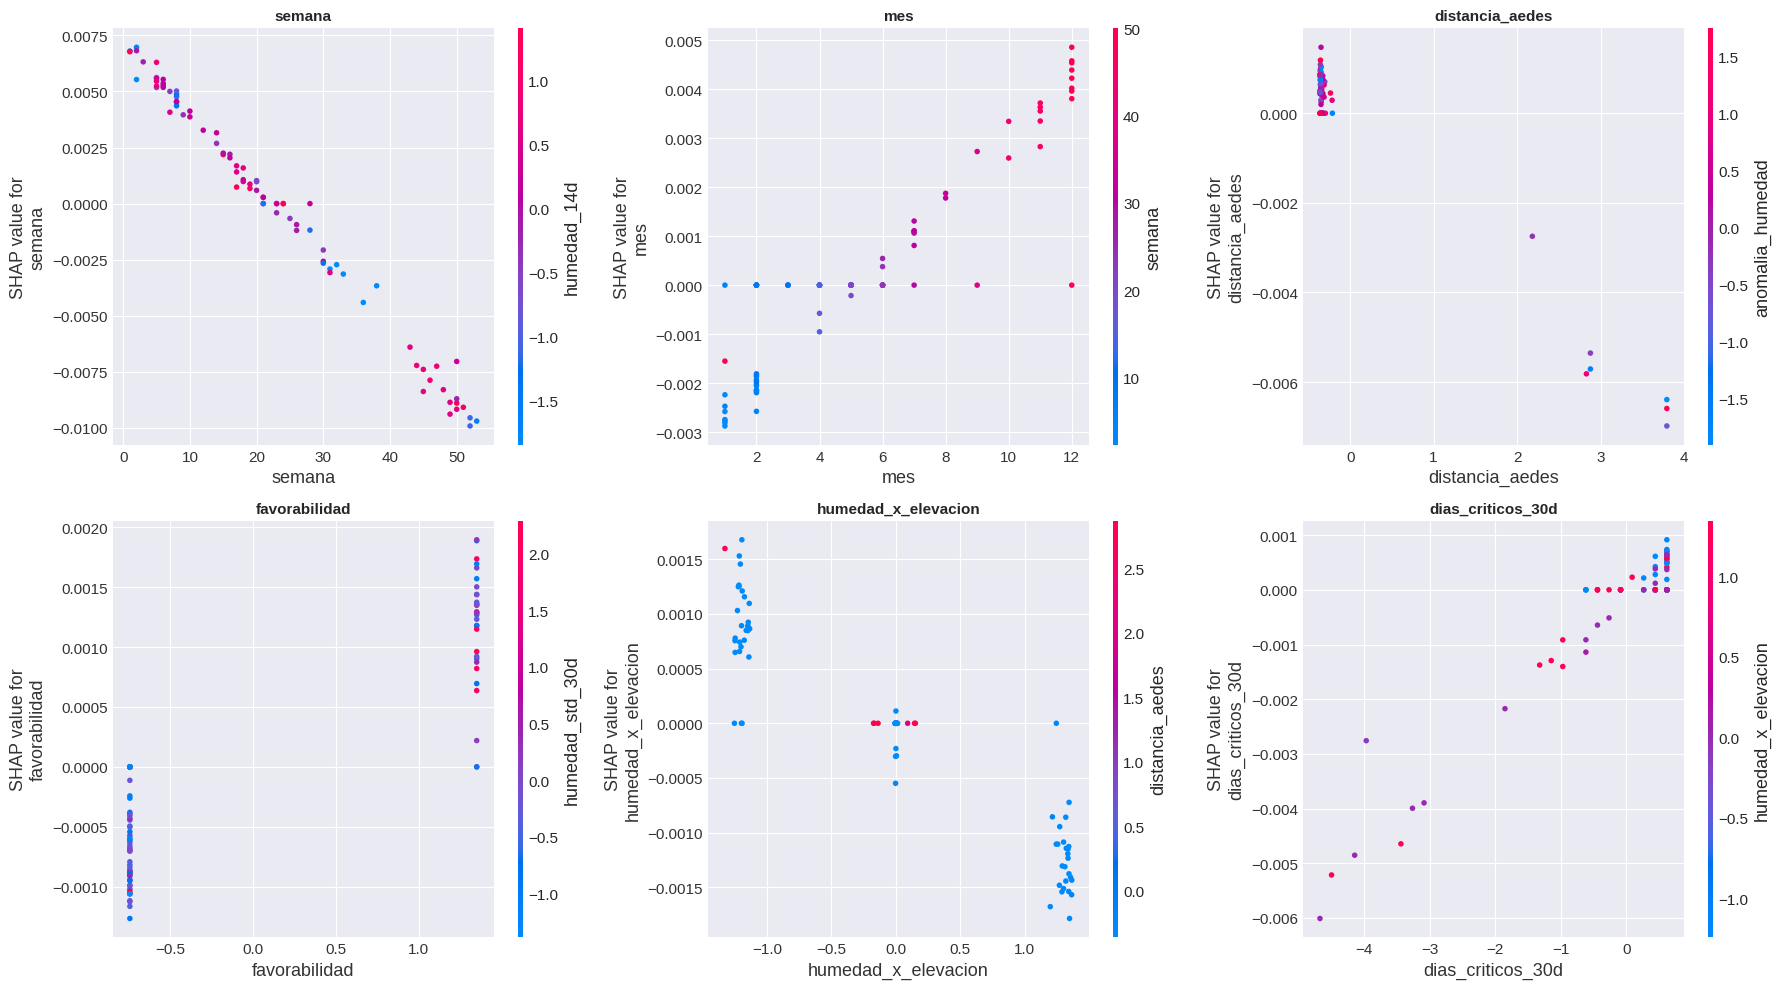

✓ SHAP dependence plots guardados: fig_tensorflow_shap_dependence.png

📊 Ejemplos de explicación individual (Waterfall plots)...


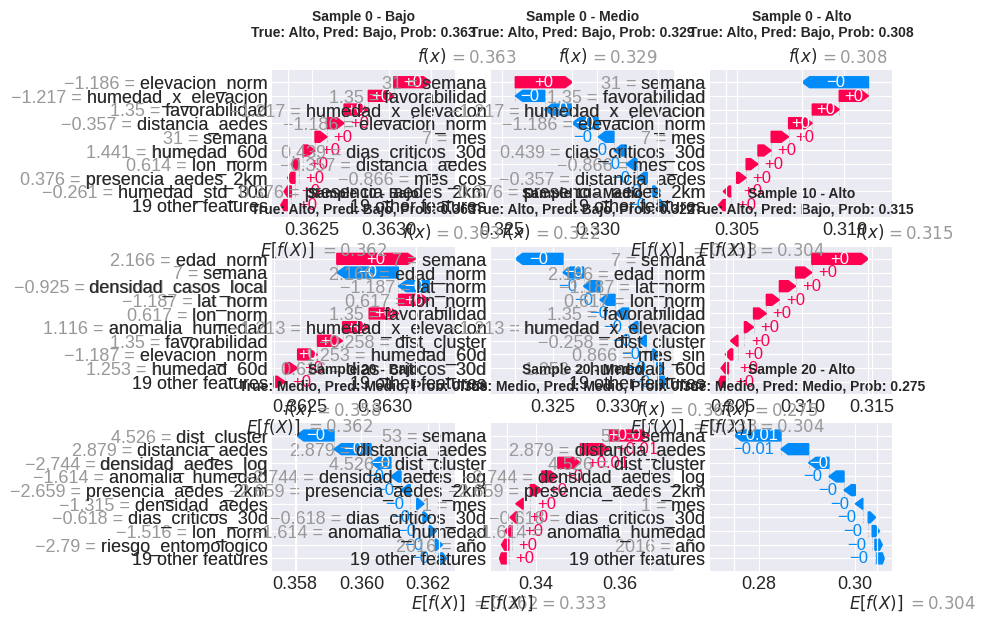

✓ SHAP waterfall plots guardados: fig_tensorflow_shap_waterfall.png
✓ SHAP results guardados: shap_results_tensorflow.json


In [ ]:
# ============================================================================
# VISUALIZACIONES SHAP
# ============================================================================

print(f"\n📊 Generando visualizaciones SHAP...")

# 1. Summary plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, (ax, class_name) in enumerate(zip(axes, class_names)):
    plt.sca(ax)
    shap.summary_plot(
        shap_values[:, :, i],  # Modified: Access SHAP values for class 'i' across all samples and features
        test_sample,
        feature_names=all_features,
        plot_type="dot",
        show=False,
        max_display=15
    )
    ax.set_title(f'SHAP Summary - Clase {class_name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('fig_tensorflow_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP summary plots guardados: fig_tensorflow_shap_summary.png")

# 2. Feature importance
print(f"\n📊 Importancia de Features (SHAP):")

feature_importance = {}
for i, class_name in enumerate(class_names):
    importance = np.abs(shap_values[:, :, i]).mean(axis=0) # Modified: Access SHAP values for class 'i'
    feature_importance[class_name] = importance

    # Top 10 features
    top_indices = np.argsort(importance)[-10:][::-1]
    print(f"\n  Top 10 features - Clase {class_name}:")
    for rank, idx in enumerate(top_indices, 1):
        print(f"    {rank:2d}. {all_features[idx]:<25s}: {importance[idx]:.4f}")

# 3. Bar plots de importancia
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, (ax, class_name) in enumerate(zip(axes, class_names)):
    importance = feature_importance[class_name]
    top_indices = np.argsort(importance)[-15:]

    ax.barh(range(len(top_indices)), importance[top_indices], alpha=0.8)
    ax.set_yticks(range(len(top_indices)))
    ax.set_yticklabels([all_features[i] for i in top_indices], fontsize=9)
    ax.set_xlabel('SHAP Value (mean |SHAP|)', fontsize=11)
    ax.set_title(f'Feature Importance - Clase {class_name}', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('fig_tensorflow_shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP importance guardado: fig_tensorflow_shap_importance.png")

# 4. Dependence plots
top_features_indices = np.argsort(feature_importance['Alto'])[-6:][::-1]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, feature_idx in enumerate(top_features_indices):
    ax = axes[idx]
    plt.sca(ax)

    shap.dependence_plot(
        feature_idx,
        shap_values[:, :, 2],  # Modified: Access SHAP values for class 2 ('Alto')
        test_sample,
        feature_names=all_features,
        show=False,
        ax=ax
    )
    ax.set_title(f'{all_features[feature_idx]}', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('fig_tensorflow_shap_dependence.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP dependence plots guardados: fig_tensorflow_shap_dependence.png")

# 5. Waterfall plots
print(f"\n📊 Ejemplos de explicación individual (Waterfall plots)...")

sample_indices = [0, 10, 20]

fig, axes = plt.subplots(len(sample_indices), 3, figsize=(20, 5*len(sample_indices)))

for row, sample_idx in enumerate(sample_indices):
    true_class = y_test[sample_idx]
    pred_class = y_pred[sample_idx]
    probs = y_pred_prob[sample_idx]

    for col, class_name in enumerate(class_names):
        ax = axes[row, col] if len(sample_indices) > 1 else axes[col]
        plt.sca(ax)

        explanation = shap.Explanation(
            values=shap_values[sample_idx, :, col], # Modified: Access SHAP values for specific sample and class
            base_values=explainer.expected_value[col],
            data=test_sample[sample_idx],
            feature_names=all_features
        )

        shap.plots.waterfall(explanation, max_display=10, show=False)

        title = f'Sample {sample_idx} - {class_name}\n'
        title += f'True: {class_names[true_class]}, '
        title += f'Pred: {class_names[pred_class]}, '
        title += f'Prob: {probs[col]:.3f}'
        ax.set_title(title, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('fig_tensorflow_shap_waterfall.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP waterfall plots guardados: fig_tensorflow_shap_waterfall.png")

# Guardar SHAP results
shap_results = {
    'feature_names': all_features,
    'class_names': class_names,
    'feature_importance': {
        clase: importance.tolist()
        for clase, importance in feature_importance.items()
    },
    'expected_values': [float(ev) for ev in explainer.expected_value]
}

with open('shap_results_tensorflow.json', 'w') as f:
    json.dump(shap_results, f, indent=2)

print("✓ SHAP results guardados: shap_results_tensorflow.json")

In [ ]:
# ============================================================================
# 18. GUARDAR MODELO Y RESULTADOS FINALES
# ============================================================================

print(f"\n{'='*80}")
print("GUARDANDO MODELO Y RESULTADOS FINALES")
print(f"{'='*80}")

# Guardar modelo completo
model.save('model_tensorflow_final.h5')
print("✓ Modelo guardado: model_tensorflow_final.h5")

# Guardar pesos
model.save_weights('model_tensorflow_weights.weights.h5')
print("✓ Pesos guardados: model_tensorflow_weights.weights.h5")

# Compilar resultados finales
final_results = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_type': 'TensorFlow/Keras Dense Neural Network',
    'dataset_info': {
        'total_samples': len(df),
        'n_features': len(all_features),
        'n_classes': 3,
        'class_distribution': metadata['class_distribution']
    },
    'training_info': {
        'total_epochs': len(history.history['loss']),
        'best_epoch': int(best_epoch),
        'best_val_loss': float(min(history.history['val_loss'])),
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'test_samples': len(X_test),
        'batch_size': BATCH_SIZE,
        'random_seed': RANDOM_SEED
    },
    'model_architecture': {
        'input_dim': input_dim,
        'hidden_layers': [128, 64, 32],
        'dropout_rates': [0.3, 0.2],
        'total_parameters': trainable_params,
        'activation': 'ReLU',
        'output_activation': 'Softmax',
        'optimizer': 'Adam',
        'loss_function': 'Categorical Crossentropy'
    },
    'test_performance': {
        'accuracy': float(accuracy),
        'balanced_accuracy': float(balanced_acc),
        'f1_macro': float(f1_macro),
        'f1_weighted': float(f1_weighted),
        'matthews_cc': float(matthews),
        'cohen_kappa': float(cohen_kappa),
        'auc_roc_macro': float(roc_auc['macro']),
        'auc_roc_micro': float(roc_auc['micro']),
        'sensitivity_macro': float(recall.mean()),
        'precision_macro': float(precision.mean())
    },
    'per_class_performance': {
        f'class_{i}': {
            'name': class_names[i],
            'precision': float(precision[i]),
            'recall': float(recall[i]),
            'f1_score': float(f1[i]),
            'support': int(support[i]),
            'auc_roc': float(roc_auc[i])
        }
        for i in range(3)
    },
    'cross_validation': {
        'n_folds': N_SPLITS,
        'mean_accuracy': float(cv_df['val_acc'].mean()),
        'std_accuracy': float(cv_df['val_acc'].std()),
        'mean_f1_macro': float(cv_df['f1_macro'].mean()),
        'std_f1_macro': float(cv_df['f1_macro'].std()),
        'mean_auc_macro': float(cv_df['auc_macro'].mean()),
        'std_auc_macro': float(cv_df['auc_macro'].std())
    },
    'confusion_matrix': cm.tolist(),
    'generalization_gap': {
        'train_test_accuracy_gap': float(gap_acc),
        'overfitting_status': 'No' if gap_acc < 0.05 else 'Leve' if gap_acc < 0.10 else 'Moderado'
    }
}

# Guardar resultados
with open('results_tensorflow_final.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print("✓ Resultados finales guardados: results_tensorflow_final.json")

# Guardar predicciones
predictions_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'confidence': confidence_scores,
    'entropy': entropy_scores,
    'correct': (y_pred == y_test).astype(int),
    'prob_clase_0': y_pred_prob[:, 0],
    'prob_clase_1': y_pred_prob[:, 1],
    'prob_clase_2': y_pred_prob[:, 2]
})
predictions_df.to_csv('predictions_tensorflow.csv', index=False)
print("✓ Predicciones guardadas: predictions_tensorflow.csv")


GUARDANDO MODELO Y RESULTADOS FINALES
✓ Modelo guardado: model_tensorflow_final.h5
✓ Pesos guardados: model_tensorflow_weights.weights.h5
✓ Resultados finales guardados: results_tensorflow_final.json
✓ Predicciones guardadas: predictions_tensorflow.csv


In [ ]:
# ============================================================================
# 19. RESUMEN EJECUTIVO FINAL
# ============================================================================

print(f"\n{'='*80}")
print("RESUMEN EJECUTIVO - MODELO TENSORFLOW (MEJORADO)")
print(f"{'='*80}\n")

print("📊 ARQUITECTURA:")
print(f"   • Tipo: Red Neuronal Densa (Feed-Forward)")
print(f"   • Framework: TensorFlow {tf.__version__} / Keras {keras.__version__}")
print(f"   • Capas: Input({input_dim}) → Dense(128) → Dense(64) → Dense(32) → Output(3)")
print(f"   • Parámetros entrenables: {trainable_params:,}")
print(f"   • Activación: ReLU (capas ocultas), Softmax (salida)")
print(f"   • Regularización: Dropout (0.3, 0.2)")
print(f"   • Inicialización: He Normal")

print(f"\n⚙️  ENTRENAMIENTO:")
print(f"   • Optimizador: Adam (lr=0.001)")
print(f"   • Loss: Categorical Crossentropy con class weights")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Epochs ejecutados: {len(history.history['loss'])}")
print(f"   • Mejor epoch: {best_epoch}")
print(f"   • Callbacks: Early Stop (patience={PATIENCE}), ReduceLR, Checkpoint")

print(f"\n📈 PERFORMANCE (TEST SET):")
print(f"   • Accuracy:           {accuracy:.4f}")
print(f"   • Balanced Accuracy:  {balanced_acc:.4f}")
print(f"   • F1-Score Macro:     {f1_macro:.4f}")
print(f"   • F1-Score Weighted:  {f1_weighted:.4f}")
print(f"   • Sensibilidad:       {recall.mean():.4f}")
print(f"   • Precisión:          {precision.mean():.4f}")
print(f"   • AUC-ROC Macro:      {roc_auc['macro']:.4f}")
print(f"   • Matthews CC:        {matthews:.4f}")
print(f"   • Cohen's Kappa:      {cohen_kappa:.4f}")

print(f"\n🔄 VALIDACIÓN CRUZADA ({N_SPLITS}-FOLD):")
print(f"   • Accuracy:     {cv_df['val_acc'].mean():.4f} ± {cv_df['val_acc'].std():.4f}")
print(f"   • F1-Macro:     {cv_df['f1_macro'].mean():.4f} ± {cv_df['f1_macro'].std():.4f}")
print(f"   • AUC-ROC:      {cv_df['auc_macro'].mean():.4f} ± {cv_df['auc_macro'].std():.4f}")

print(f"\n⚠️  GENERALIZACIÓN:")
print(f"   • Gap Train-Test:  {gap_acc:.4f}")
print(f"   • Estado:          {final_results['generalization_gap']['overfitting_status']}")

print(f"\n🎯 CUMPLIMIENTO DE OBJETIVOS:")
objetivos = [
    ('Accuracy > 0.80', accuracy > 0.80),
    ('F1-Score > 0.75', f1_macro > 0.75),
    ('AUC-ROC > 0.85', roc_auc['macro'] > 0.85),
    ('Sensibilidad > 0.85', recall.mean() > 0.85),
    ('Gap < 0.10', gap_acc < 0.10)
]

for objetivo, cumple in objetivos:
    status = '✓' if cumple else '✗'
    print(f"   {status} {objetivo}")

print(f"\n🔍 EXPLICABILIDAD:")
print(f"   • Método: SHAP (Kernel Explainer)")
print(f"   • Muestras analizadas: {n_explain}")
print(f"   • Top features identificadas por clase")
print(f"   • Visualizaciones: Summary, Importance, Dependence, Waterfall")

print(f"\n💾 ARCHIVOS GENERADOS:")
archivos = [
    'model_tensorflow_best.h5',
    'model_tensorflow_final.h5',
    'model_tensorflow_weights.h5',
    'results_tensorflow_final.json',
    'predictions_tensorflow.csv',
    'training_history_tensorflow.csv',
    'cross_validation_results_tensorflow.csv',
    'sets_comparison_tensorflow.csv',
    'shap_results_tensorflow.json',
    'fig_tensorflow_learning_curves.png',
    'fig_tensorflow_confusion_matrix.png',
    'fig_tensorflow_roc_curves.png',
    'fig_tensorflow_calibration.png',
    'fig_tensorflow_precision_recall.png',
    'fig_tensorflow_uncertainty.png',
    'fig_tensorflow_cross_validation.png',
    'fig_tensorflow_sets_comparison.png',
    'fig_tensorflow_shap_summary.png',
    'fig_tensorflow_shap_importance.png',
    'fig_tensorflow_shap_dependence.png',
    'fig_tensorflow_shap_waterfall.png'
]

for archivo in archivos:
    print(f"   • {archivo}")

print(f"\n{'='*80}")
print("✅ NOTEBOOK TENSORFLOW MEJORADO COMPLETADO EXITOSAMENTE")
print(f"{'='*80}")

print("\n📋 MEJORAS IMPLEMENTADAS:")
print("   ✓ Validación cruzada estratificada (5-fold)")
print("   ✓ Métricas epidemiológicas completas (15 métricas)")
print("   ✓ Análisis de calibración del modelo")
print("   ✓ Curvas Precision-Recall")
print("   ✓ Análisis de incertidumbre y entropía")
print("   ✓ Comparación detallada entre conjuntos")
print("   ✓ Análisis de errores y patrones")
print("   ✓ Explicabilidad con SHAP (completa)")
print("   ✓ Intervalos de confianza (CV)")
print("   ✓ Evaluación de overfitting")

print("\n→ Continuar con Notebook 07: Modelo XGBoost")
print("\n" + "="*80)

# FIN DEL NOTEBOOK



RESUMEN EJECUTIVO - MODELO TENSORFLOW (MEJORADO)

📊 ARQUITECTURA:
   • Tipo: Red Neuronal Densa (Feed-Forward)
   • Framework: TensorFlow 2.19.0 / Keras 3.10.0
   • Capas: Input(28) → Dense(128) → Dense(64) → Dense(32) → Output(3)
   • Parámetros entrenables: 14,147
   • Activación: ReLU (capas ocultas), Softmax (salida)
   • Regularización: Dropout (0.3, 0.2)
   • Inicialización: He Normal

⚙️  ENTRENAMIENTO:
   • Optimizador: Adam (lr=0.001)
   • Loss: Categorical Crossentropy con class weights
   • Batch size: 32
   • Epochs ejecutados: 53
   • Mejor epoch: 33
   • Callbacks: Early Stop (patience=20), ReduceLR, Checkpoint

📈 PERFORMANCE (TEST SET):
   • Accuracy:           0.3140
   • Balanced Accuracy:  0.3441
   • F1-Score Macro:     0.1770
   • F1-Score Weighted:  0.1642
   • Sensibilidad:       0.3441
   • Precisión:          0.4353
   • AUC-ROC Macro:      0.5882
   • Matthews CC:        0.0886
   • Cohen's Kappa:      0.0157

🔄 VALIDACIÓN CRUZADA (5-FOLD):
   • Accuracy:     